# Astro Hack Week

## Starting point

The plot below shows 5 different regions (all connected by a single model) of a simulated dataset, and the best fit w/ `pymc`. 

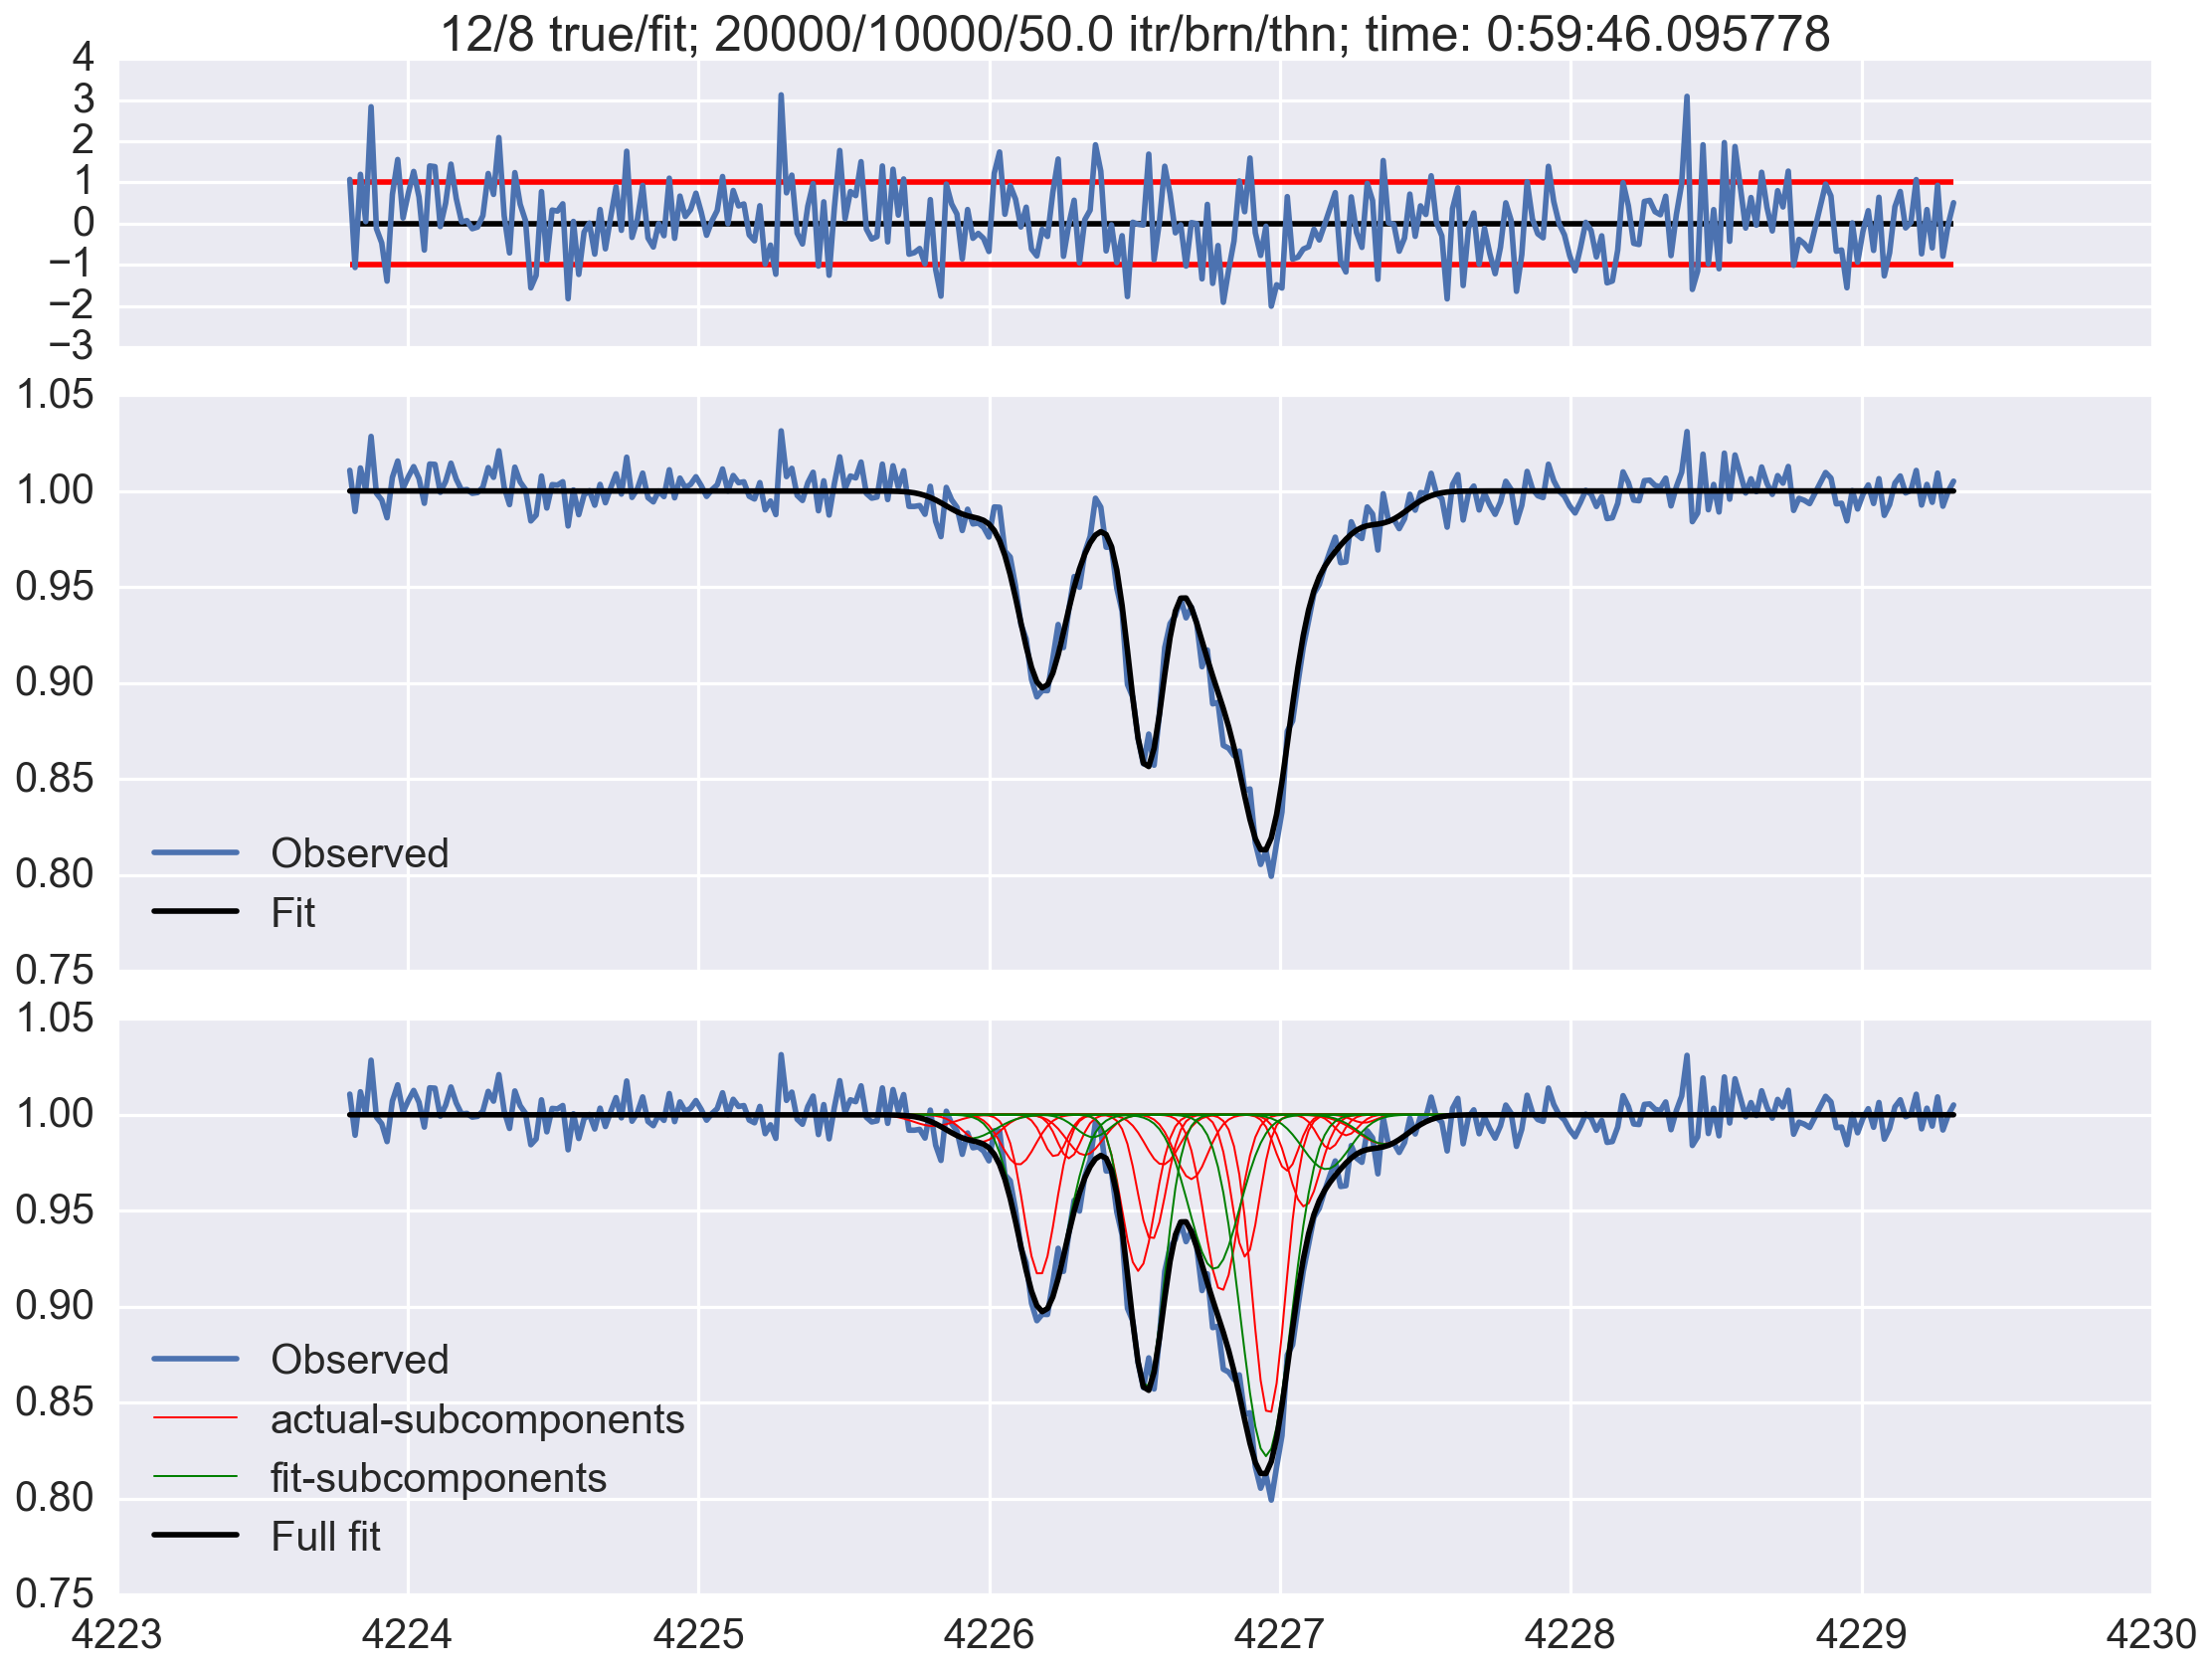

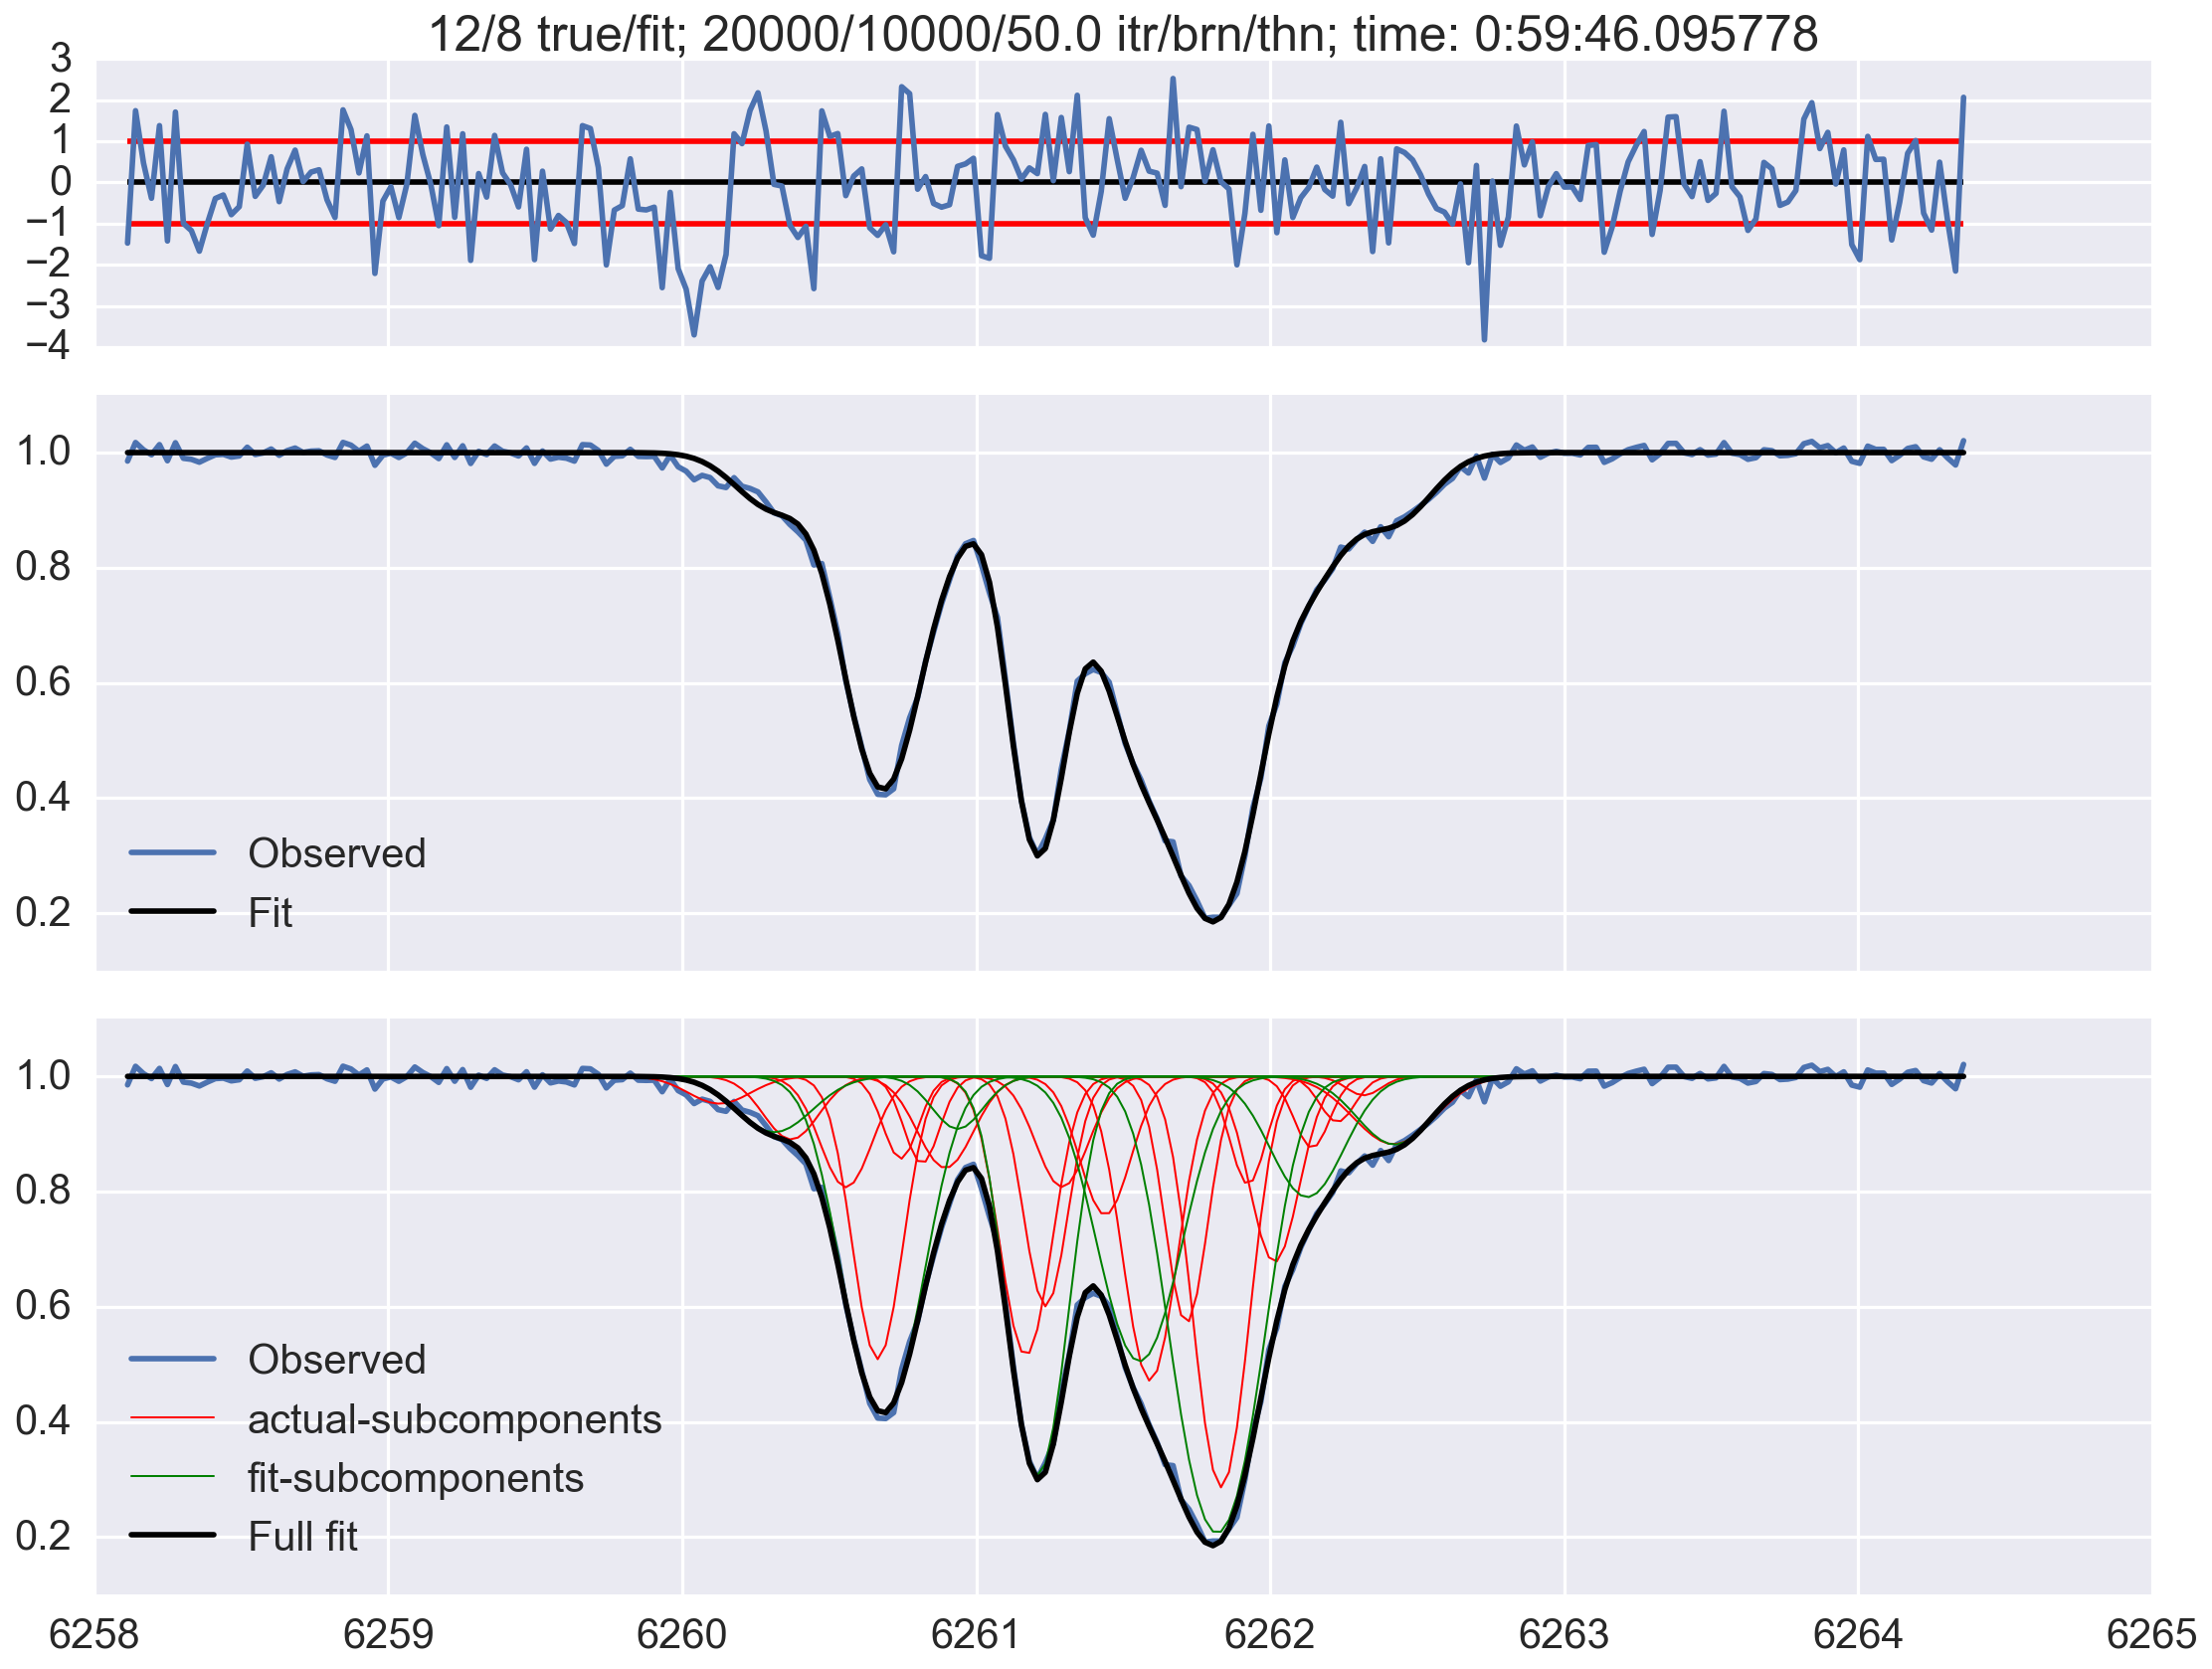

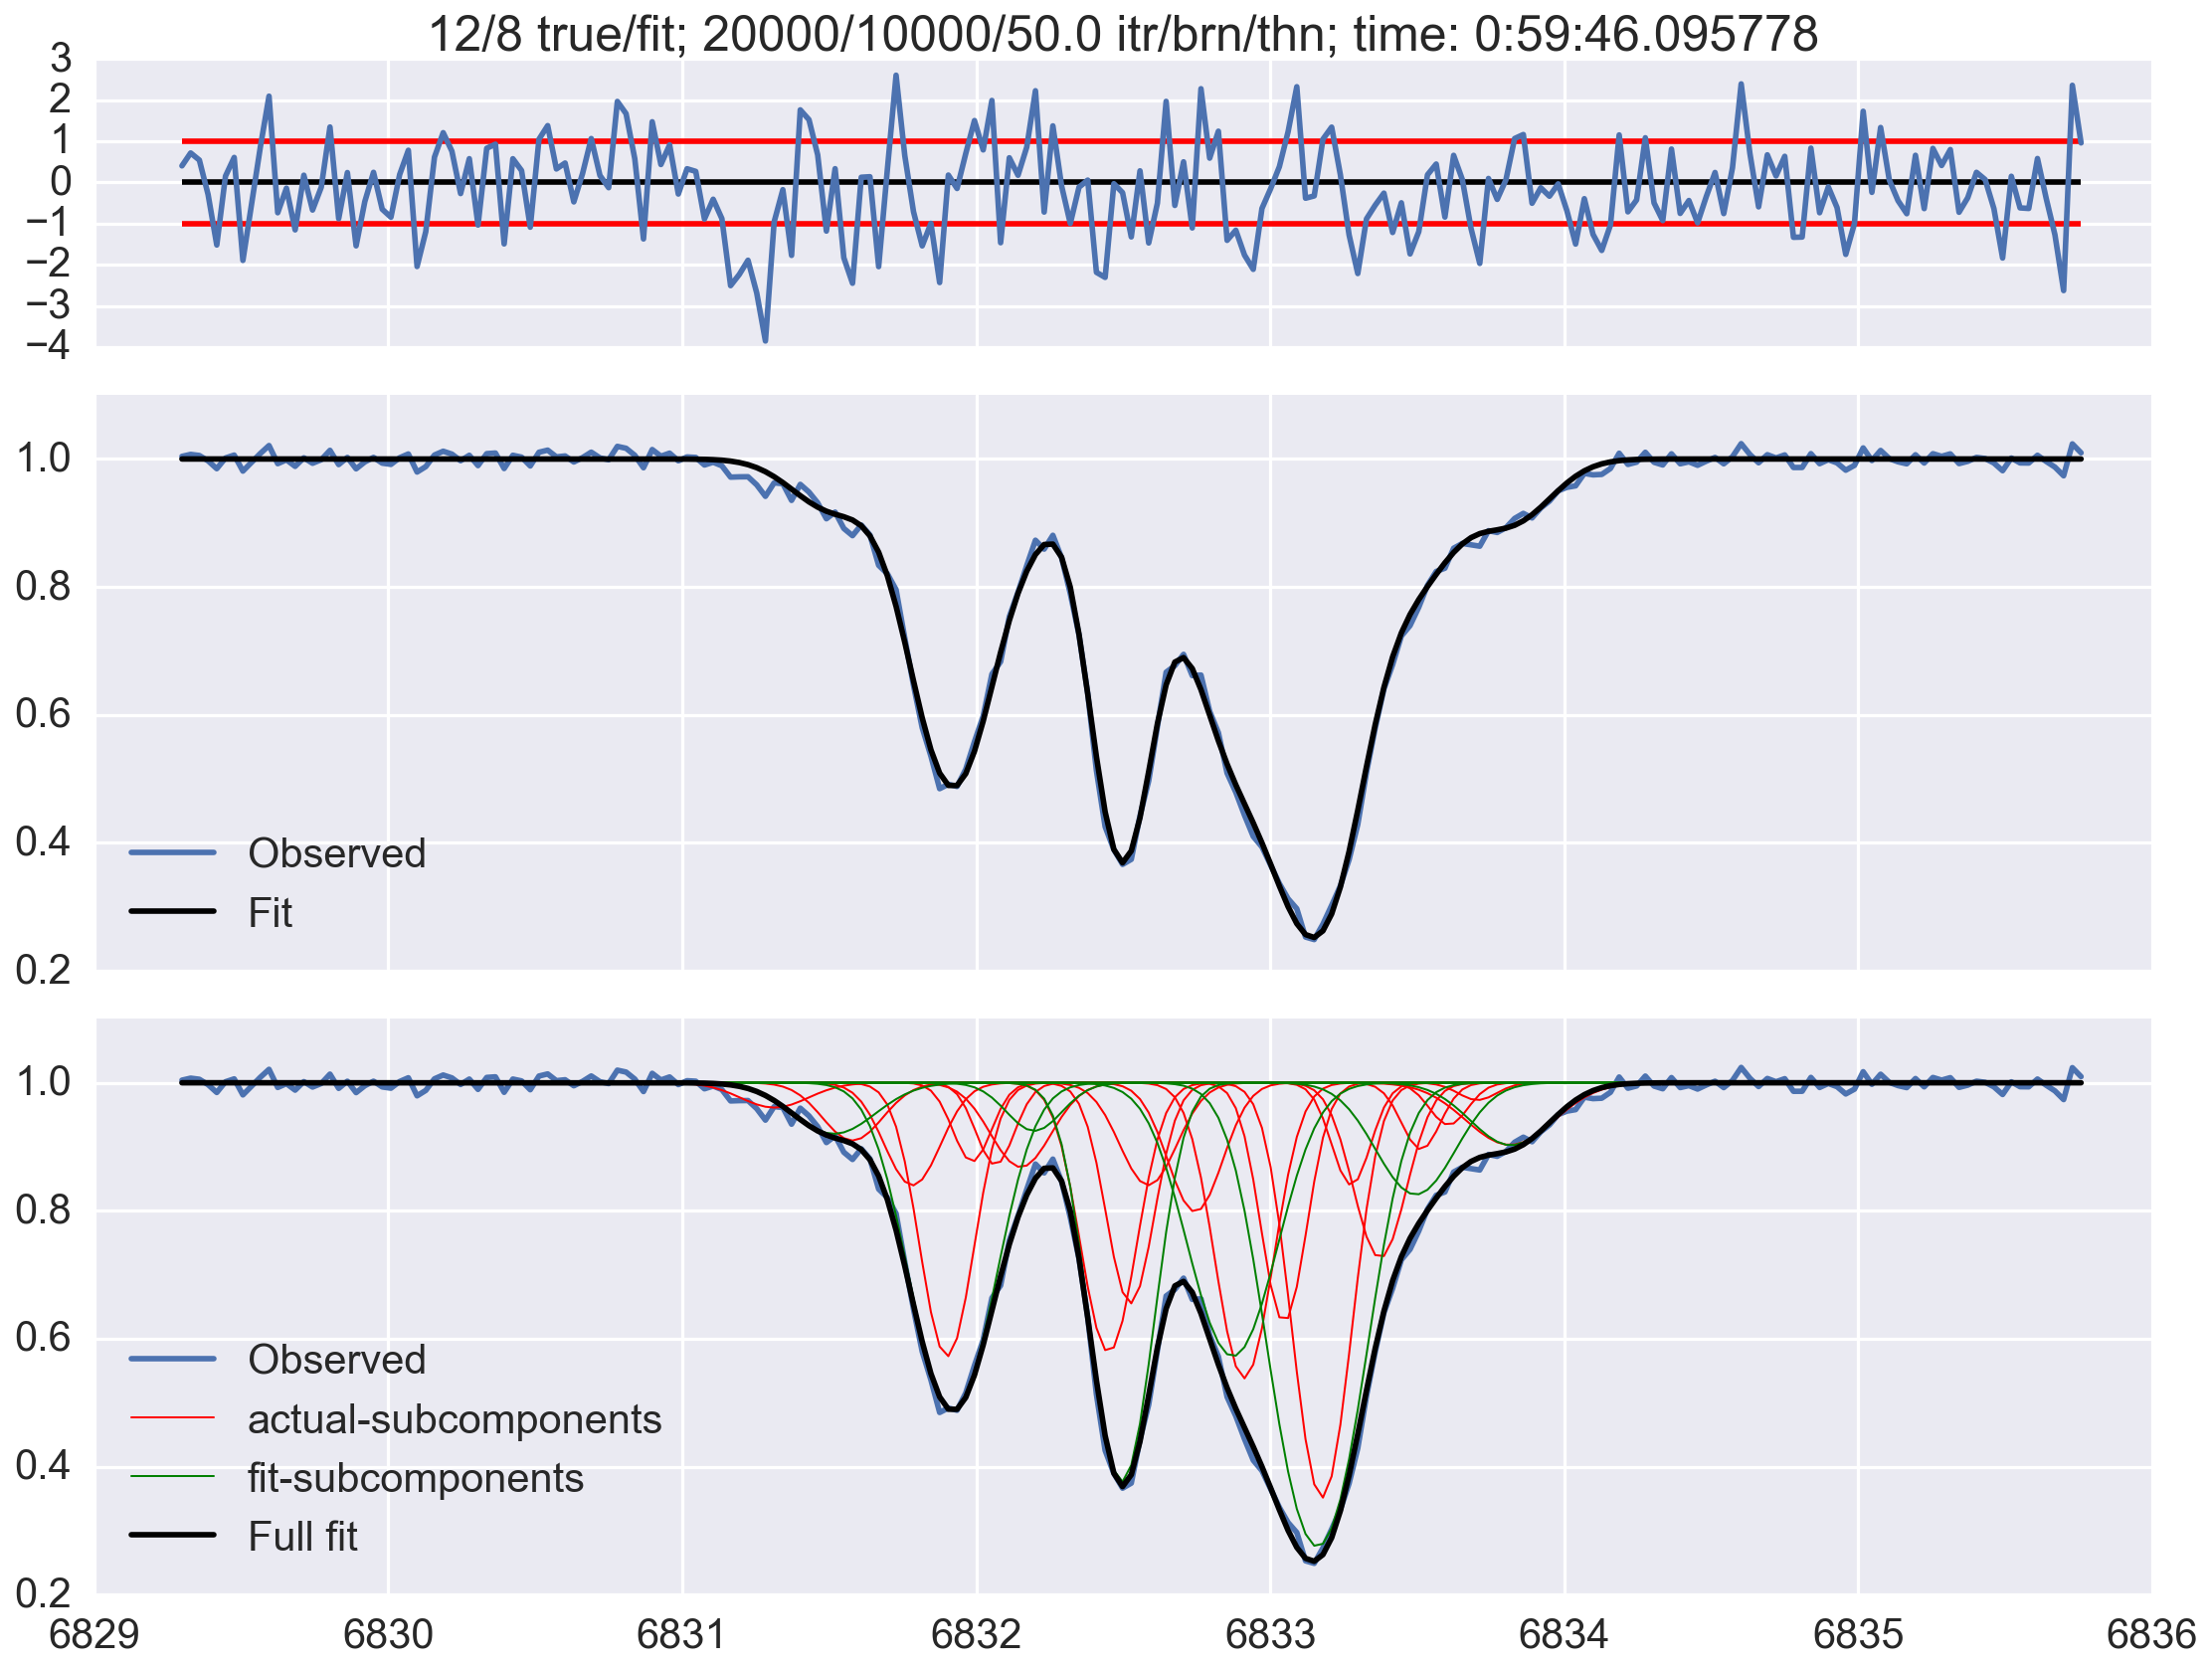

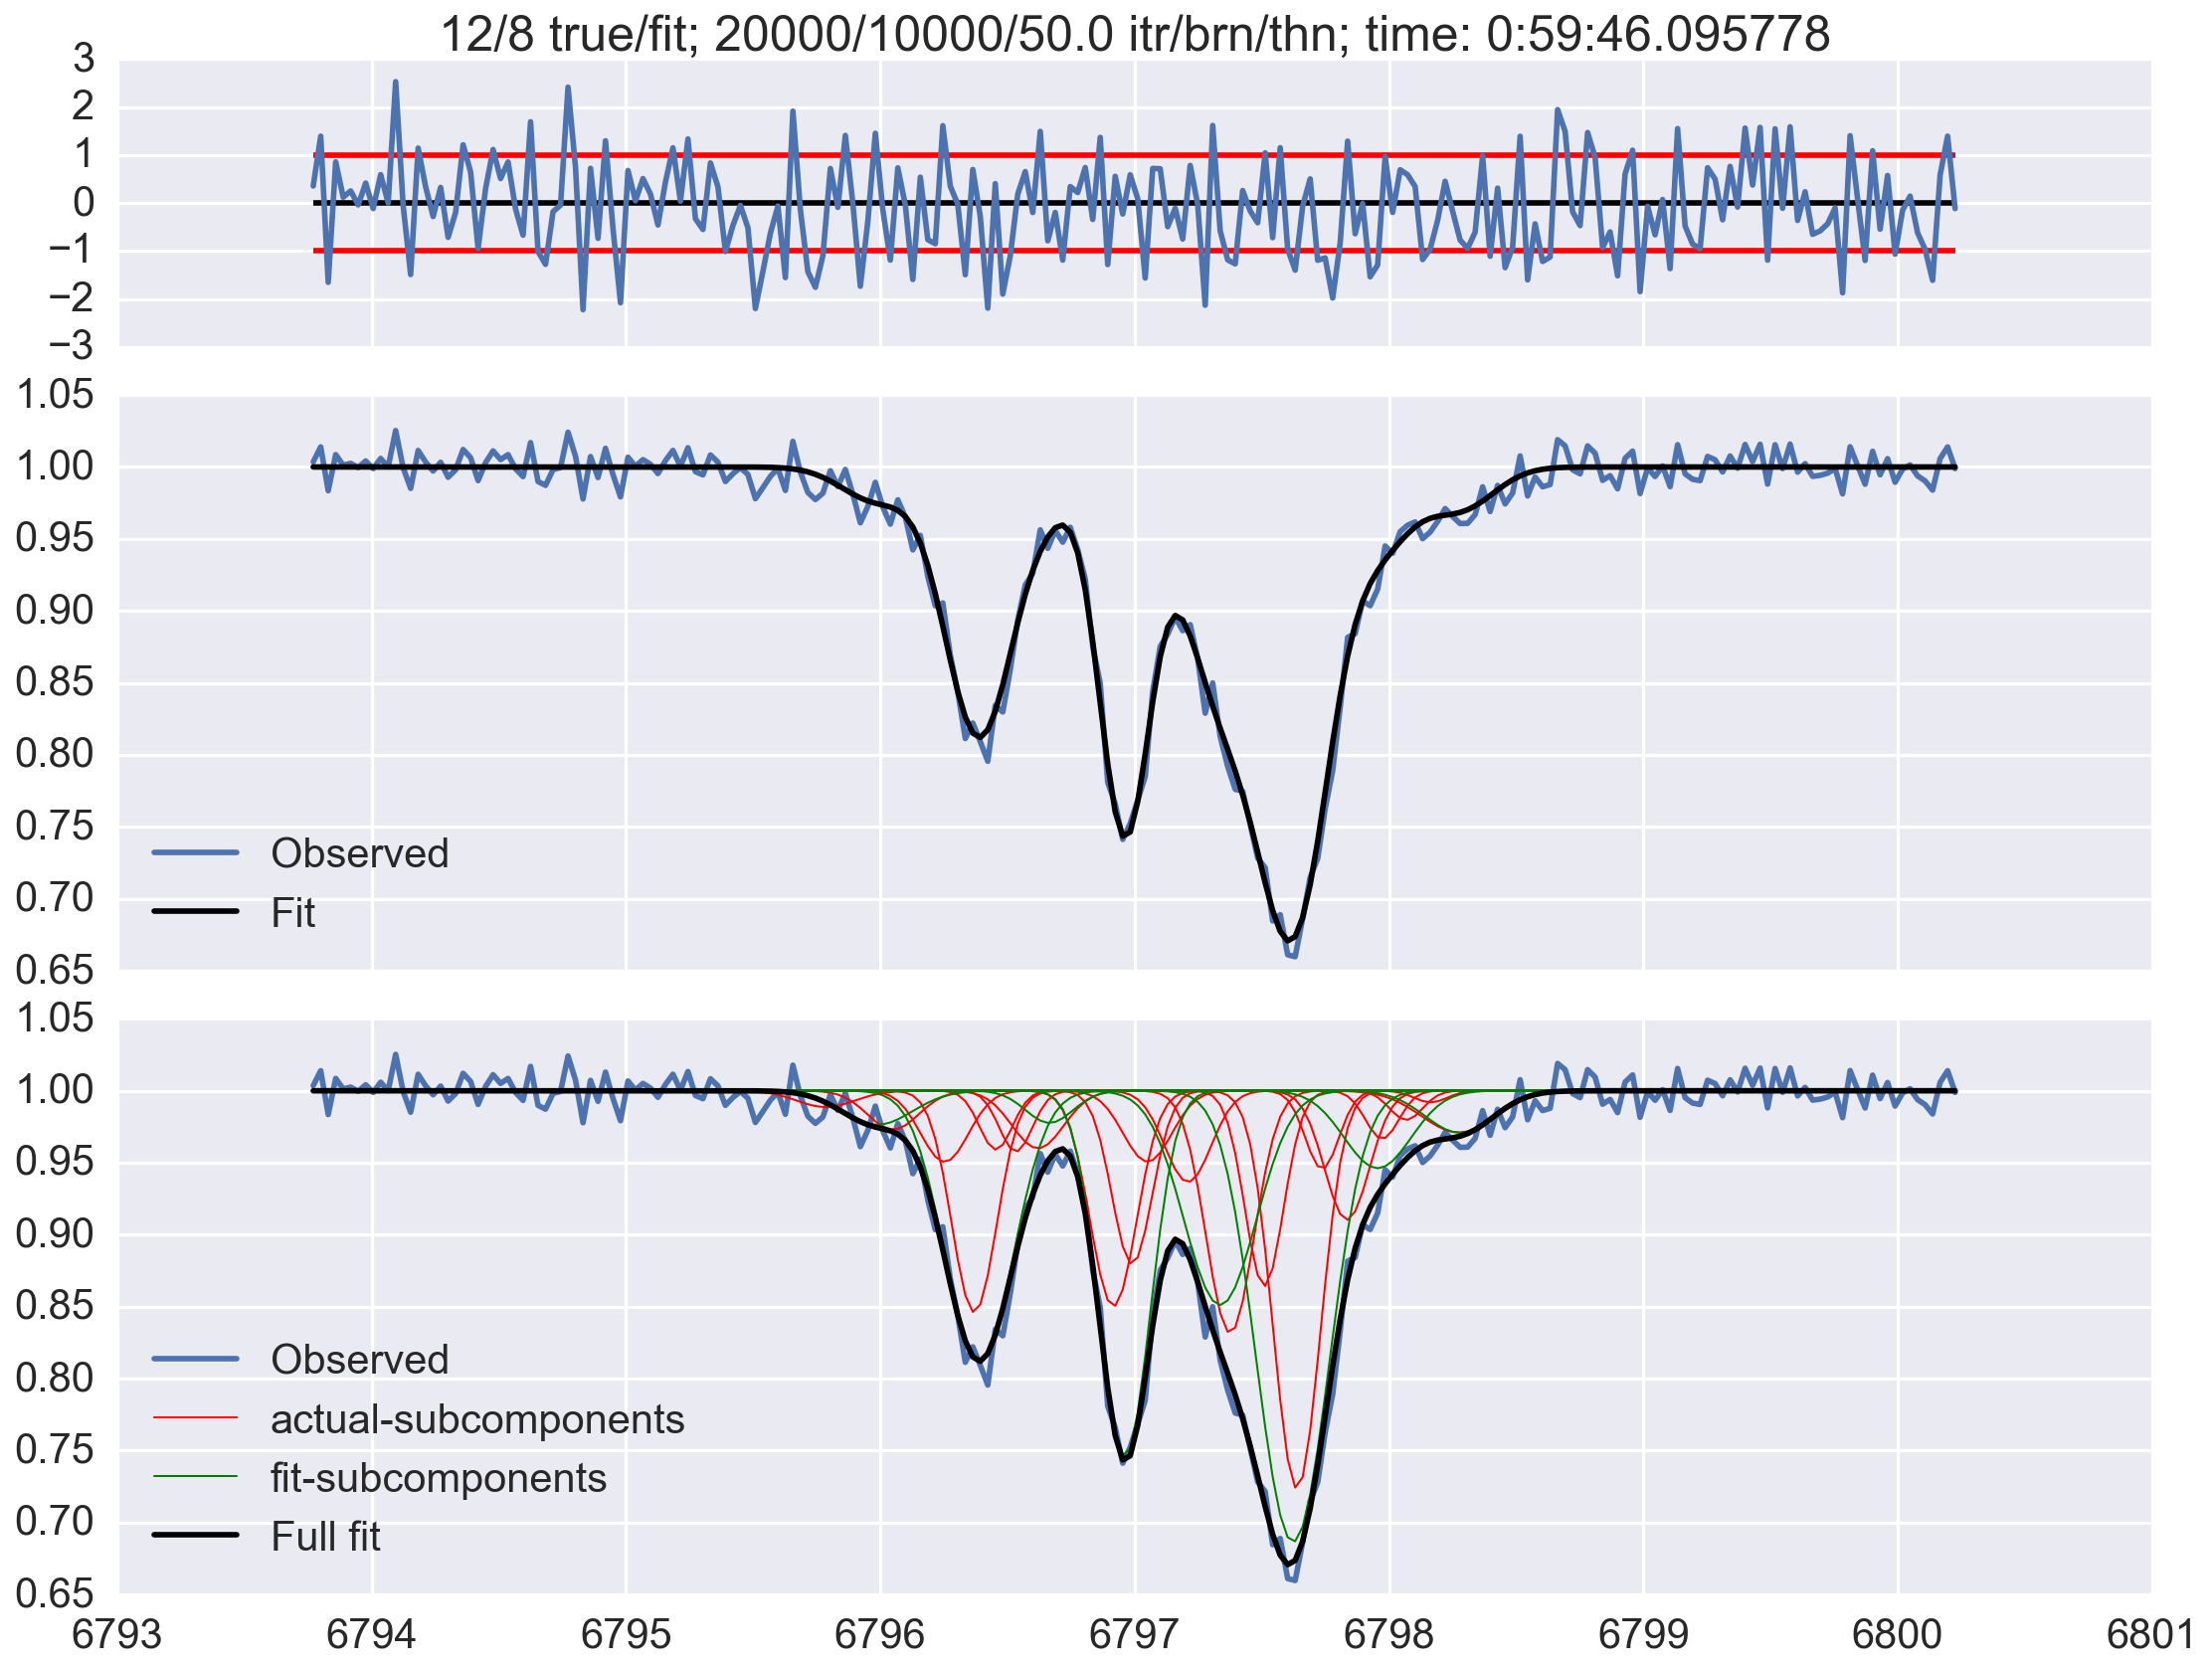

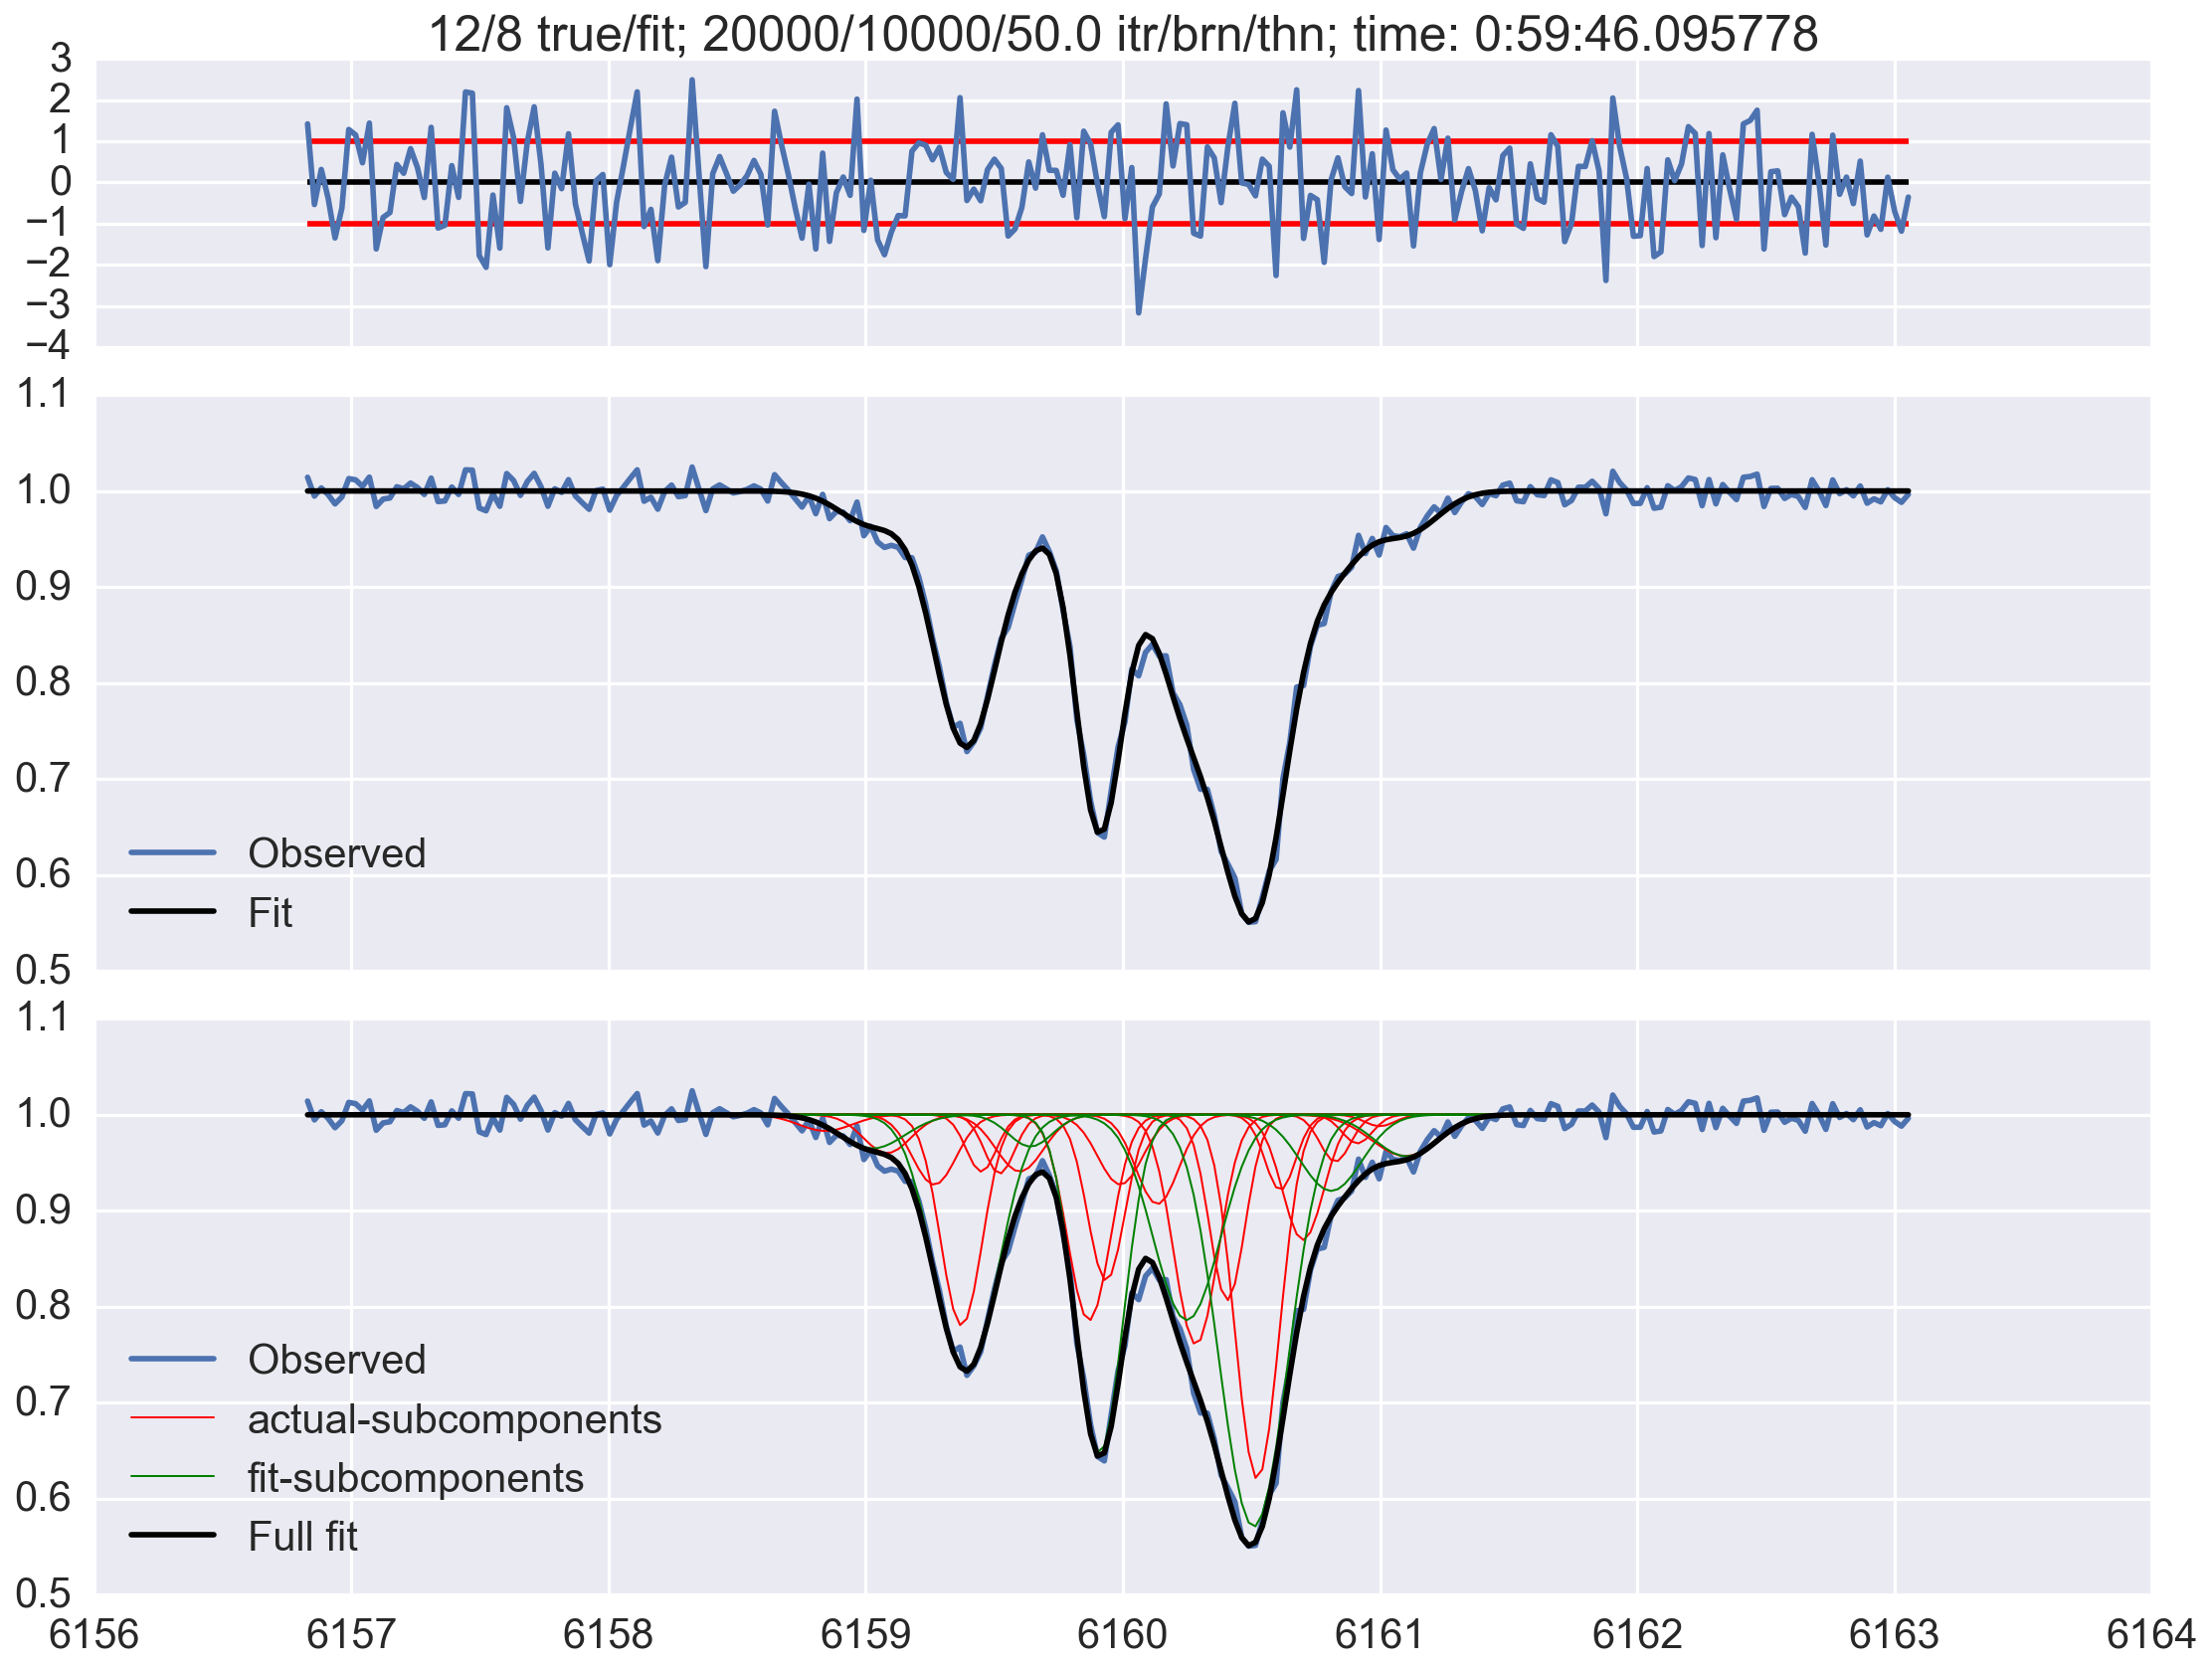

In [58]:
for region_index, region_wavelength in enumerate(wavelengthList):
    f = plt.figure(figsize=(16, 12))
    gs = GridSpec(3, 1, height_ratios=[1, 2, 2])
    ax3 = plt.subplot(gs[2])
    ax1 = plt.subplot(gs[0], sharex=ax3)
    ax2 = plt.subplot(gs[1], sharex=ax3)
    ax1.plot(wavelengthList[region_index], (observed[region_index] - fit_flux[region_index]['flux']) / onesigmaerror)
    ax1.hlines(1.0, wavelengthList[region_index][0], wavelengthList[region_index][-1], color='red', linestyles='-')
    ax1.hlines(0, wavelengthList[region_index][0], wavelengthList[region_index][-1], color='black')
    ax1.hlines(-1.0, wavelengthList[region_index][0], wavelengthList[region_index][-1], color='red', linestyles='-')
    ax2.plot(wavelengthList[region_index], observed[region_index], label="Observed")
    ax2.plot(wavelengthList[region_index], fit_flux[region_index]['flux'], color='black', label="Fit")
    ax2.legend(loc='best')
    ax3.plot(wavelengthList[region_index], observed[region_index], label="Observed")
    for observed_index, row in enumerate(true_component_parameters):
        flux = absorb.find_tau(subwavelengthList[region_index], [row], atomDict, )[0]
        flux = convolve.convolve_psf(VoigtAbsorption(co_add_from_subsample(flux)), estimated_instrument_profile)
        if observed_index == 0:
            ax3.plot(wavelengthList[region_index], flux, color="red", label="actual-subcomponents", linewidth=1.0)
        else:
            ax3.plot(wavelengthList[region_index], flux, color="red", linewidth=1.0)
    for final_index, row in enumerate(final_fit):
        flux = absorb.find_tau(subwavelengthList[region_index], [row], atomDict, )[0]
        flux = convolve.convolve_psf(VoigtAbsorption(co_add_from_subsample(flux)), estimated_instrument_profile)
        if final_index == 0:
            ax3.plot(wavelengthList[region_index], flux, color="green", label="fit-subcomponents", linewidth=1.0)
        else:
            ax3.plot(wavelengthList[region_index], flux, color="green", linewidth=1.0)
    ax3.plot(wavelengthList[region_index], fit_flux[region_index]['flux'], color='black', label="Full fit")
    ax3.legend(loc='best')
    ax3.xaxis.set_major_formatter(x_formatter)
    xticklabels = ax1.get_xticklabels() + ax2.get_xticklabels()
    plt.setp(xticklabels, visible=False)
    f.tight_layout()
    f.subplots_adjust(hspace=.10)
    ax1.set_title(str(true_components) + "/" 
                  + str(fit_components) 
                  + " true/fit; " + str(iterations)+ "/" 
                  + str(burn) + "/" + str(thin) + " itr/brn/thn; time: " + sampletime)
#     pdf.savefig()
#     plt.close()
# pdf.close()


In [59]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

from __future__ import absolute_import, division, print_function
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.pyplot import GridSpec
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import mpld3
import numpy as np
import pandas as pd
import os, sys
from tqdm import tqdm
import warnings
import astropy
import pymc as mc
import itertools as it
import string
from glob import glob
import datetime

import barak
from barak import absorb
from barak import convolve
from barak import voigt
from barak import pyvpfit

In [60]:
warnings.simplefilter("ignore")
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_context('poster', font_scale=1.3)

In [61]:
atomDict = absorb.readatom('../src/MM_VPFIT_2012-06-05_noiso.dat')
pixel_size = 1.3 # km/s per pixel
subsample_factor = int(1)

In [88]:
def VoigtAbsorption(x):
    return np.exp(-x)

def subsample(wave, subsample_factor=subsample_factor, pixel_size=pixel_size):
    # Assumes wave was created by make_constant_dv_wa_scale
    # pixel_size is in km/s of the original wave array
    begin_size = wave[1] - wave[0]
    end_size = wave[-1] - wave[-2]
    subwave = barak.sed.make_constant_dv_wa_scale(wave[0] - begin_size/2.0, wave[-1] + end_size, pixel_size/subsample_factor)
    return subwave[:len(wave) * subsample_factor]

def co_add_from_subsample(subsampled_flux, subsample_factor=subsample_factor):
    starting_length = len(subsampled_flux)
    intermediate_step = subsampled_flux.reshape(starting_length/subsample_factor, subsample_factor)/float(subsample_factor)
    return np.sum(intermediate_step, axis=1)

def create_wavelength_chunk(rest_wavelength, z_begin, z_end, pixel_size=1.3, tolerance=2.0):
    """Returns a wavelength array that covers the redshift range of interest
    for a given transition.
    pixel_size in km/s
    tolerance in Angstroms."""
    starting = (z_begin + 1 ) * rest_wavelength
    ending = (z_end + 1 ) * rest_wavelength
    return barak.sed.make_constant_dv_wa_scale(starting - tolerance, ending + tolerance, pixel_size)


In [89]:
onesigmaerror = 0.01
#onesigmaerror = np.average(err1)
instrument_profile = 5.0 #km/s
estimated_instrument_profile = 5.0
true_components = 12

z_lower = 1.6272486
z_upper = 1.6282109
b_lower = 3.0
b_upper = 7.5
N_lower = 9.5
N_upper = 13.0
lineList = []

wavelength_buffer = 2.0 # Wavelength region extension

species = {}
species['FeII'] = {}
# species['FeII']['1608'] = 1608.4507986
#species['FeII']['1611'] = 1611.2004037
species['FeII']['2382'] = 2382.7640777
# species['FeII']['2600'] = 2600.1721140
# species['FeII']['2344'] = 2344.2127470
# species['FeII']['2586'] = 2586.6493120
# species['AlII'] = {}
# species['AlII']['1670'] = 1670.7886100 

# species['AlIII'] = {}
# species['AlIII']['1862'] = 1862.798581
# species['AlIII']['1854'] = 1854.708966

# species['MgI'] = {}
# species['MgI']['2852'] = 2852.9627970

# species['MgII'] = {}
# species['MgII']['2796'] = 2796.3537860
# species['MgII']['2803'] = 2803.5309820


In [90]:
regions = []
wavelengthList = []
for specie in species:
    for transition in species[specie]:
        rest_wavelength = species[specie][transition]
        wave = create_wavelength_chunk(rest_wavelength, z_lower, z_upper)
        wavelengthList.append(wave)
        regions.append([specie, transition, np.average(wave)])
        
wavelengthList = np.array(wavelengthList)
wavelength = np.array(np.hstack(wavelengthList))
subwavelengthList = []
for cutwave in wavelengthList:
    subwavelengthList.append(subsample(cutwave))
subwavelengthList = np.array(subwavelengthList)

noiseList = np.array([np.random.normal(0.0, onesigmaerror, len(wave)) for wave in wavelengthList])
noise = np.hstack(noiseList)


In [91]:
starting_model = [
#  ['FeII', 11.47903, 1.6272486, 5.8986],
#  ['FeII', 11.80684, 1.6273509, 4.9074],
#  ['FeII', 12.04197, 1.6274293, 4.2774],
 ['FeII', 12.53468, 1.6274744, 3.7264],
#  ['FeII', 11.81651, 1.6275073, 1.0    ],
#  ['FeII', 11.8325,  1.6275375, 1.036 ],
#  ['FeII', 11.98327, 1.6275711, 4.9331],
#  ['FeII', 12.53598, 1.6276858, 3.9991],
#  ['FeII', 12.37782, 1.6277142, 2.9156],
#  ['FeII', 12.04839, 1.6277377, 4.4162],
#  ['FeII', 12.14221, 1.6277991, 4.0641],
#  ['FeII', 12.60239, 1.6278632, 4.2045],
#  ['FeII', 12.4193,  1.6279151, 2.5551],
#  ['FeII', 12.84099, 1.6279648, 3.9983],
#  ['FeII', 11.9488,  1.628003,  1.1738],
#  ['FeII', 12.28364, 1.6280408, 3.766 ],
#  ['FeII', 11.72462, 1.6280943, 1.0938],
#  ['FeII', 11.49827, 1.6281306, 1.0164],
#  ['FeII', 11.08618, 1.6281681, 1.0   ],
#  ['FeII', 12.00147, 1.6282109, 8.2485],
]


In [92]:
# This is when you want to tie species together with fixed relative column densities
species_column_density_correction = {}
species_column_density_correction["MgI"] = -1.72
species_column_density_correction["MgII"] =  0.08
species_column_density_correction["AlII"] = -1.02
species_column_density_correction["AlIII"] = -1.62
species_column_density_correction["SiII"] =  0.06
species_column_density_correction["CrII"] = -1.82
species_column_density_correction["FeII"] =  0.00
species_column_density_correction["MnII"] = -1.97
species_column_density_correction["NiII"] = -1.25
species_column_density_correction["TiII"] = -1.54
species_column_density_correction["ZnII"] = -1.82


In [93]:
true_component_parameters = []
for row in starting_model:
    for specie in species:
        true_component_parameters.append([specie, row[2], row[3], row[1] + species_column_density_correction[specie]])

In [94]:
observed = {}
for region_index, region_wavelength in enumerate(wavelengthList):
    observed[region_index] = {}
    flux = absorb.find_tau(subwavelengthList[region_index], true_component_parameters, atomDict, )[0]
    observed[region_index]['observed'] = co_add_from_subsample(convolve.convolve_psf(VoigtAbsorption(flux), instrument_profile)) + noiseList[region_index]
total_observed = np.hstack([observed[region_index]['observed'] for region_index, region_wavelength in enumerate(wavelengthList)])

(0, 1.1)

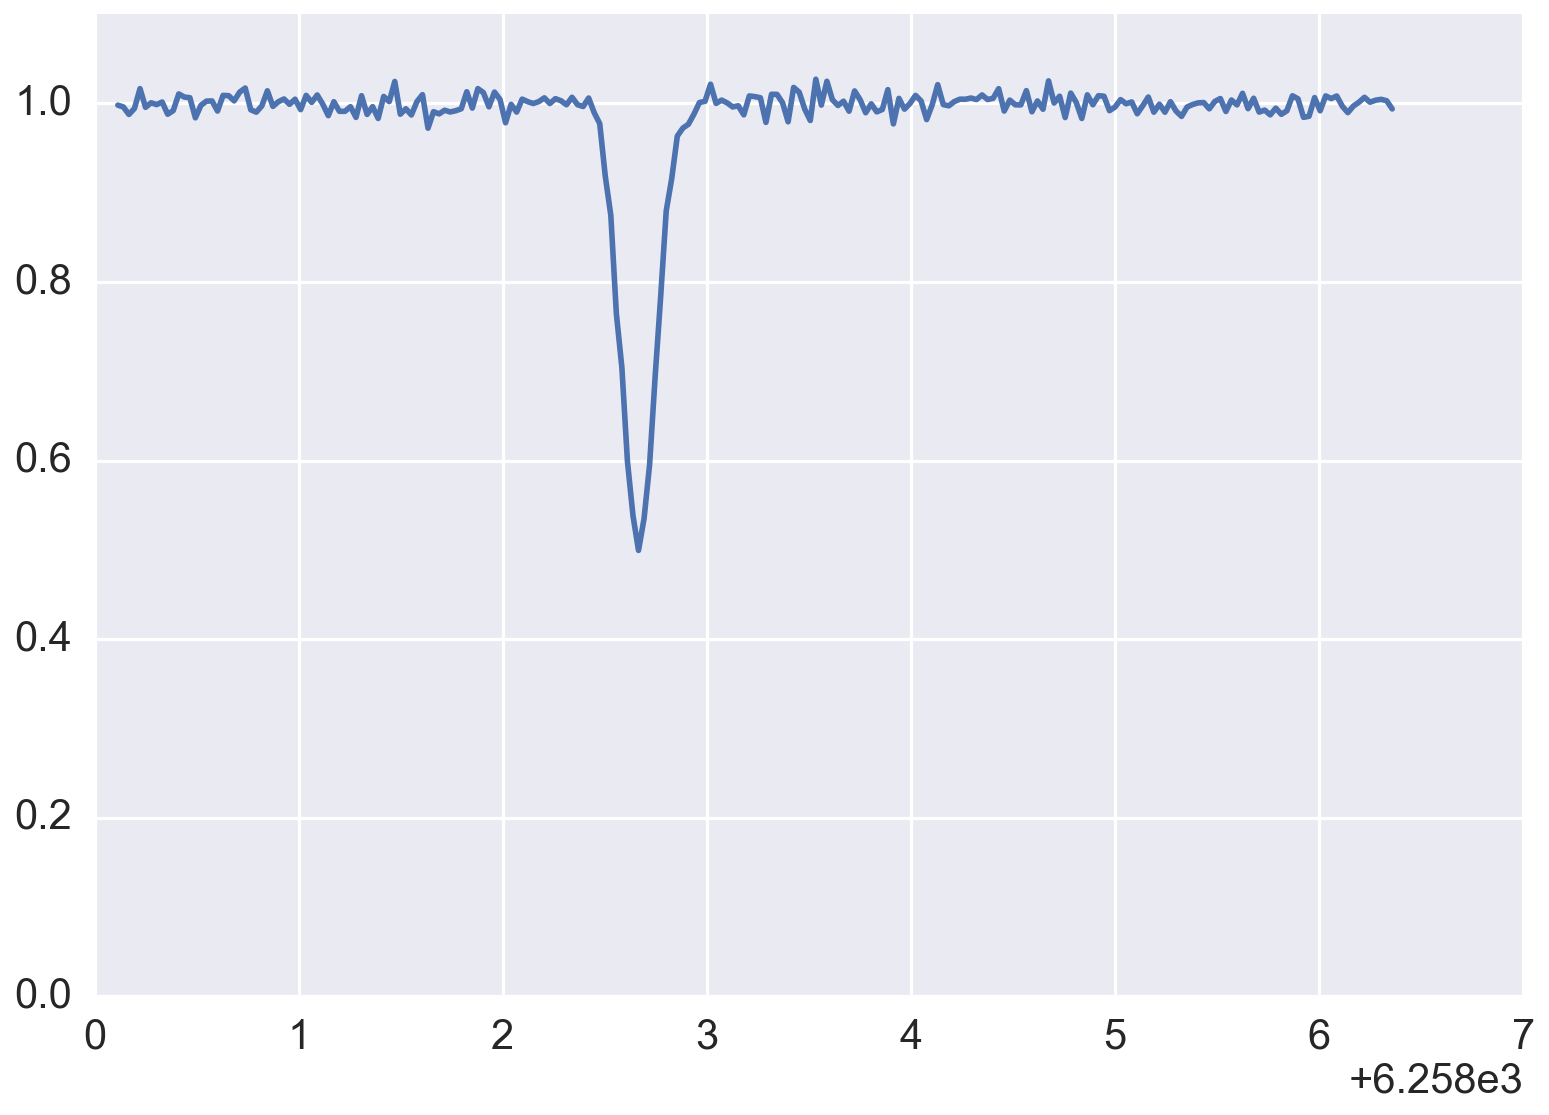

In [95]:
index = 0
plt.plot(wavelengthList[index], observed[index]['observed'])
plt.ylim(0, 1.1)


In [70]:
wavelength_buffer = 2.0
lower_labels = []
for x in it.combinations_with_replacement(string.ascii_lowercase, 2):
    lower_labels.append(x[0] + x[1])
#todo implement labeling.            
timestamp = "demo-data"

for i, region in enumerate(wavelengthList):
    np.savetxt(timestamp + "." + str(i) + regions[i][0] + ".ascii",         (np.transpose([wavelengthList[i], observed[i]['observed'], np.ones_like(region) * onesigmaerror])))

with open(timestamp + ".true.13", 'w') as fh:
    #header
    print("   *")
#     print >>fh, "   *"
    for i, region in enumerate(wavelengthList):
        print(timestamp + "." + str(i) + regions[i][0]  + ".ascii   1   ", region[0] + wavelength_buffer/2.0, region[-1] - wavelength_buffer/2.0,             "vfwhm=" + str(round(estimated_instrument_profile, 2)) + " ! " + "".join(regions[i][:2]))
    print("  *")
#         print >>fh, timestamp + "." + str(i) + regions[i][0]  + ".ascii   1   ", region[0] + wavelength_buffer/2.0, region[-1] - wavelength_buffer/2.0,             "vfwhm=" + str(round(estimated_instrument_profile, 2)) + " ! " + "".join(regions[i][:2])
#     print >>fh, "  *"
    #body
    count = -1
    for index, row in enumerate(true_component_parameters):
        if not index % len(species):
            count += 1
            label = lower_labels[count]
        else:
            label = lower_labels[count].upper()
        print(row[0], str(row[3]), str(row[1]) + label, str(row[2]) + label, "  0.00E+00QA      0.00   1.00E+00  0 !    ")


   *
demo-data.0FeII.ascii   1    6259.11358727 6263.35825846 vfwhm=5.0 ! FeII2382
  *
FeII 12.53468 1.6274744aa 3.7264aa   0.00E+00QA      0.00   1.00E+00  0 !    


In [71]:
master_ion = "FeII"
wavelengthList = []
observed = []
errList = []
for infile in sorted(glob("demo-data*" + master_ion + ".ascii")):
    wav, flx, err = np.loadtxt(infile, unpack=True)
    wavelengthList.append(wav)
    observed.append(flx)
    errList.append(err)

err = np.hstack(errList)
total_observed = np.hstack(observed)
subwavelengthList = []
for cutwave in wavelengthList:
    subwavelengthList.append(subsample(cutwave))

subwavelengthList = np.array(subwavelengthList)


In [73]:
#fit_species = "FeII"
fit_components = 1
N_tol = 0.1
b_tol = 0.1
z_tol = 0.00001
ip_tol = 0.5
estimated_variables = {}
fit_N_lower = N_lower - N_tol
fit_N_upper = N_upper + N_tol
fit_b_lower = 3.0
fit_b_upper = b_upper + 2 * b_tol
fit_z_lower = z_lower - z_tol
fit_z_upper = z_upper + z_tol
# Instrument profile
fit_instrument_profile_lower = instrument_profile - ip_tol
fit_instrument_profile_upper = instrument_profile + ip_tol

estimated_variables = {}
for index, redshift in enumerate(np.linspace(fit_z_lower, fit_z_upper, num=fit_components)):
    component = index
    estimated_variables[component] = {}
    estimated_variables[component]['fit_b'] = mc.Uniform("est_b_" + str(component), fit_b_lower, fit_b_upper)
    estimated_variables[component]['fit_z'] = mc.Uniform("est_z_" + str(component), fit_z_lower, fit_z_upper, value=redshift)

#estimated_instrument_profile = mc.Uniform("est_IP", fit_instrument_profile_lower, fit_instrument_profile_upper)
estimated_instrument_profile = instrument_profile

#std deviation of the noise, converted to precision by tau = 1/sigma**2
#std_deviation = 1./mc.Uniform("std", 0, 1)**2
#std_deviation = 1./(noise**2)
std_deviation = 1./(err**2)

In [74]:
physical_fit_components = []
#for index, redshift in enumerate(np.linspace(fit_z_lower, fit_z_upper, num=fit_components)):
for component in range(fit_components):
    physical_fit_components.append([estimated_variables[component]['fit_z'], estimated_variables[component]['fit_b']])


species = {}
species['FeII'] = {}
# species['FeII']['1608'] = 1608.4507986
#species['FeII']['1611'] = 1611.2004037
species['FeII']['2382'] = 2382.7640777
# species['FeII']['2600'] = 2600.1721140
# species['FeII']['2344'] = 2344.2127470
# species['FeII']['2586'] = 2586.6493120

regions = []
for specie in species:
    for transition in species[specie]:
        rest_wavelength = species[specie][transition]
        wave = create_wavelength_chunk(rest_wavelength, z_lower, z_upper)
        regions.append([specie, transition, np.average(wave)])

fit_component_parameters = []
for index in range(fit_components):
    component = index
    for specie in species:
        fit_component_parameters.append([specie,
                                         physical_fit_components[component][0],
                                         physical_fit_components[component][1],
                                         mc.Uniform("est_N_" + specie + "_" + str(component), fit_N_lower, fit_N_upper)])


In [75]:
@mc.deterministic( trace=False )
def generated_flux(regions=len(wavelengthList), 
                   fit_component_guesses=fit_component_parameters,
                   fit_instrument_profile=estimated_instrument_profile):
    """Creates the absorption for the components"""
    fit_flux = []
    for region_index in range(regions):
        flux = absorb.find_tau(subwavelengthList[region_index], fit_component_guesses, atomDict, )[0]
        fit_flux.append(co_add_from_subsample(convolve.convolve_psf(VoigtAbsorption(flux), fit_instrument_profile)))
    return np.hstack(fit_flux)


In [76]:
potentials = {}
for component in range(fit_components - 1):
    @mc.potential
    def order_restriction( m1 = estimated_variables[component]['fit_z'], m2 = estimated_variables[component + 1]['fit_z']):
        if m1 < m2:
            return 0
        else:
            return 1 - np.exp(100000. * (m1 - m2))
    potentials[component] = order_restriction


In [77]:
observations = mc.Normal("obs", generated_flux, std_deviation, value=total_observed, observed=True)


In [78]:
trymodel = mc.Model(list(set([x[1] for x in fit_component_parameters])) +
                    list(set([x[2] for x in fit_component_parameters])) +
                    list(set([x[3] for x in fit_component_parameters])) + 
                    [std_deviation] + [potentials[restriction] for restriction in potentials])
# + [estimated_instrument_profile])



In [79]:
# Suggested best practice to do the following:
# However, I find with large models (>35 components) it blows up all the RAM, so currently not doing this.
map_ = mc.MAP(trymodel)
first_fit = datetime.datetime.now()
map_.fit()
trymcmc = mc.MCMC( trymodel )
print("Initial fit time: ", str(datetime.datetime.now() - first_fit))

Initial fit time:  0:00:00.478575


In [80]:
trymcmc = mc.MCMC( trymodel )
starttime = datetime.datetime.now()
print("Starting time: ", starttime)
iterations = 20000
burn=10000
thin=50.0
# %prun
trymcmc.sample(iter=iterations, burn=burn, thin=thin)
finishtime = datetime.datetime.now()
sampletime = str(finishtime - starttime)
print("\nTook:", sampletime, " to finish", str(iterations), "iterations.")

Starting time:  2016-08-29 17:38:08.290413
 [-----------------100%-----------------] 20000 of 20000 complete in 107.2 sec
Took: 0:01:47.196360  to finish 20000 iterations.


In [81]:
final_fit = []
for row in fit_component_parameters:
    final_fit.append([row[0], row[1].value, row[2].value, row[3].value])

final_fit = sorted(final_fit, key=lambda x:x[1])

In [82]:
fit_flux = {}
for region_index, region_wavelength in enumerate(wavelengthList):
    fit_flux[region_index] = {}
    flux = absorb.find_tau(subwavelengthList[region_index], final_fit, atomDict, )[0]
    fit_flux[region_index]['flux'] = co_add_from_subsample(convolve.convolve_psf(VoigtAbsorption(flux),
                                                                                 estimated_instrument_profile))


In [83]:
for region_index, region_wavelength in enumerate(wavelengthList):
    print(region_index, len(observed[region_index]))


0 231
1 231
2 219
3 220
4 234


In [84]:
x_formatter = mpl.ticker.ScalarFormatter(useOffset=False)

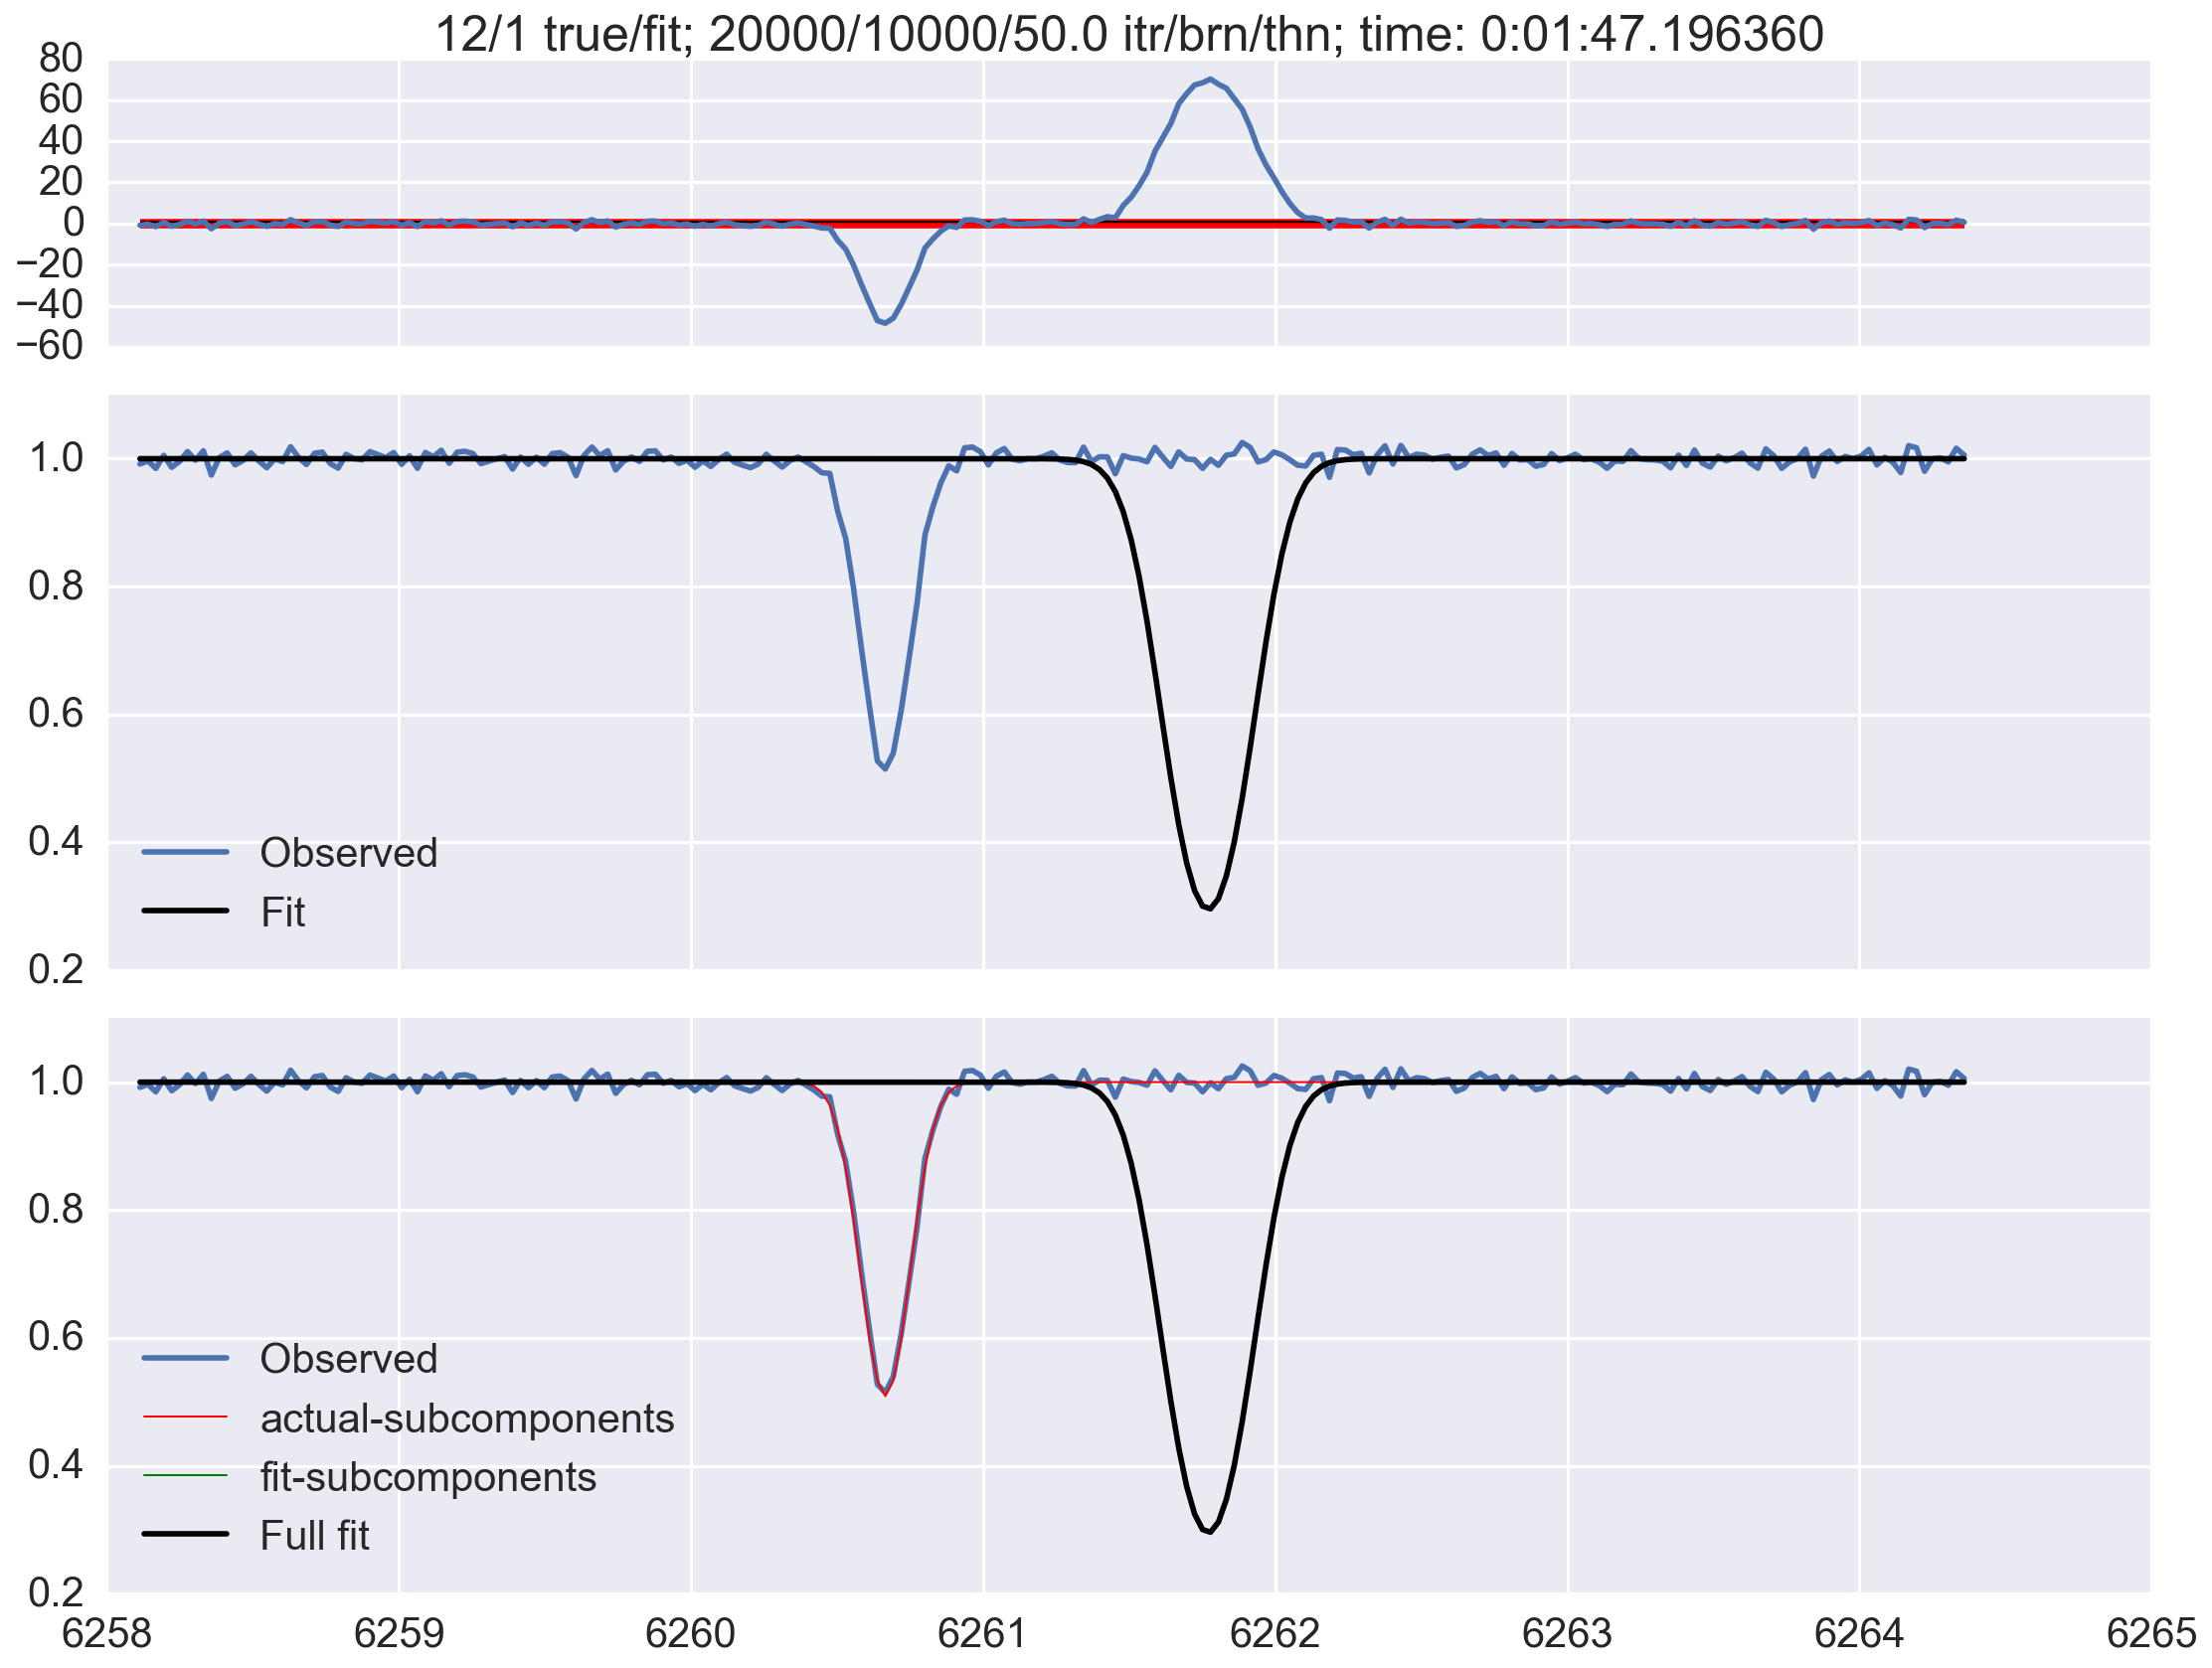

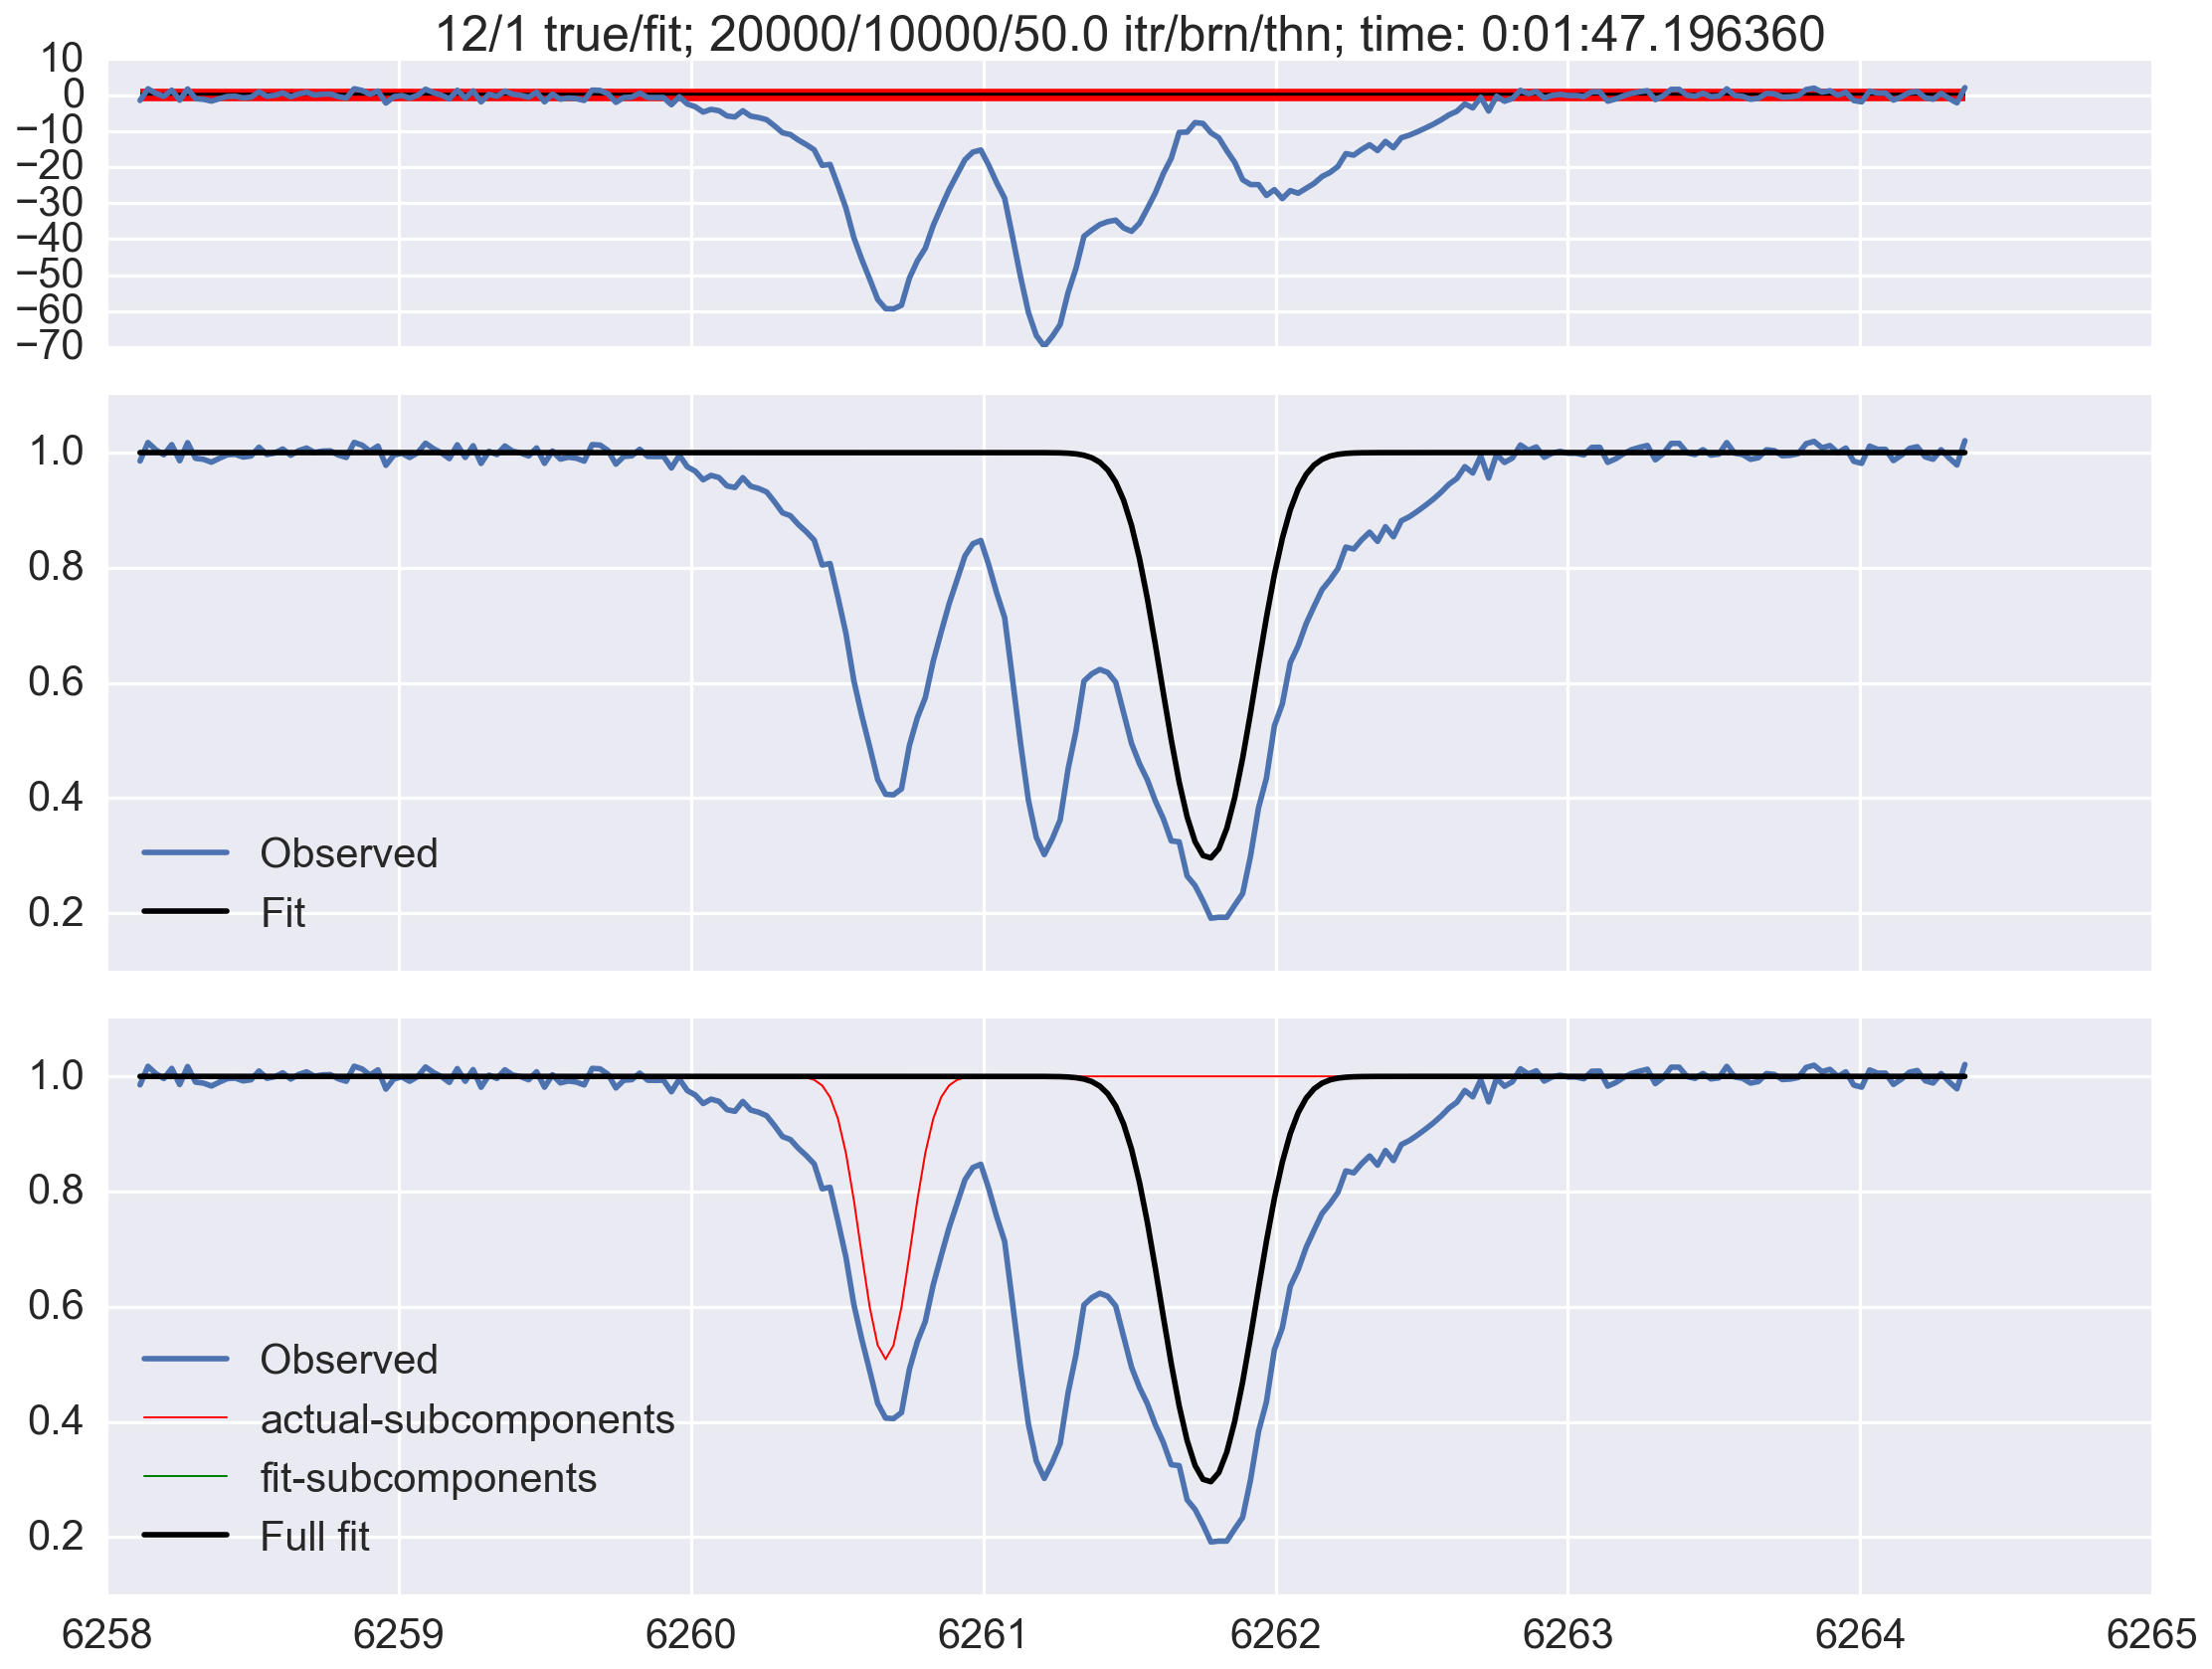

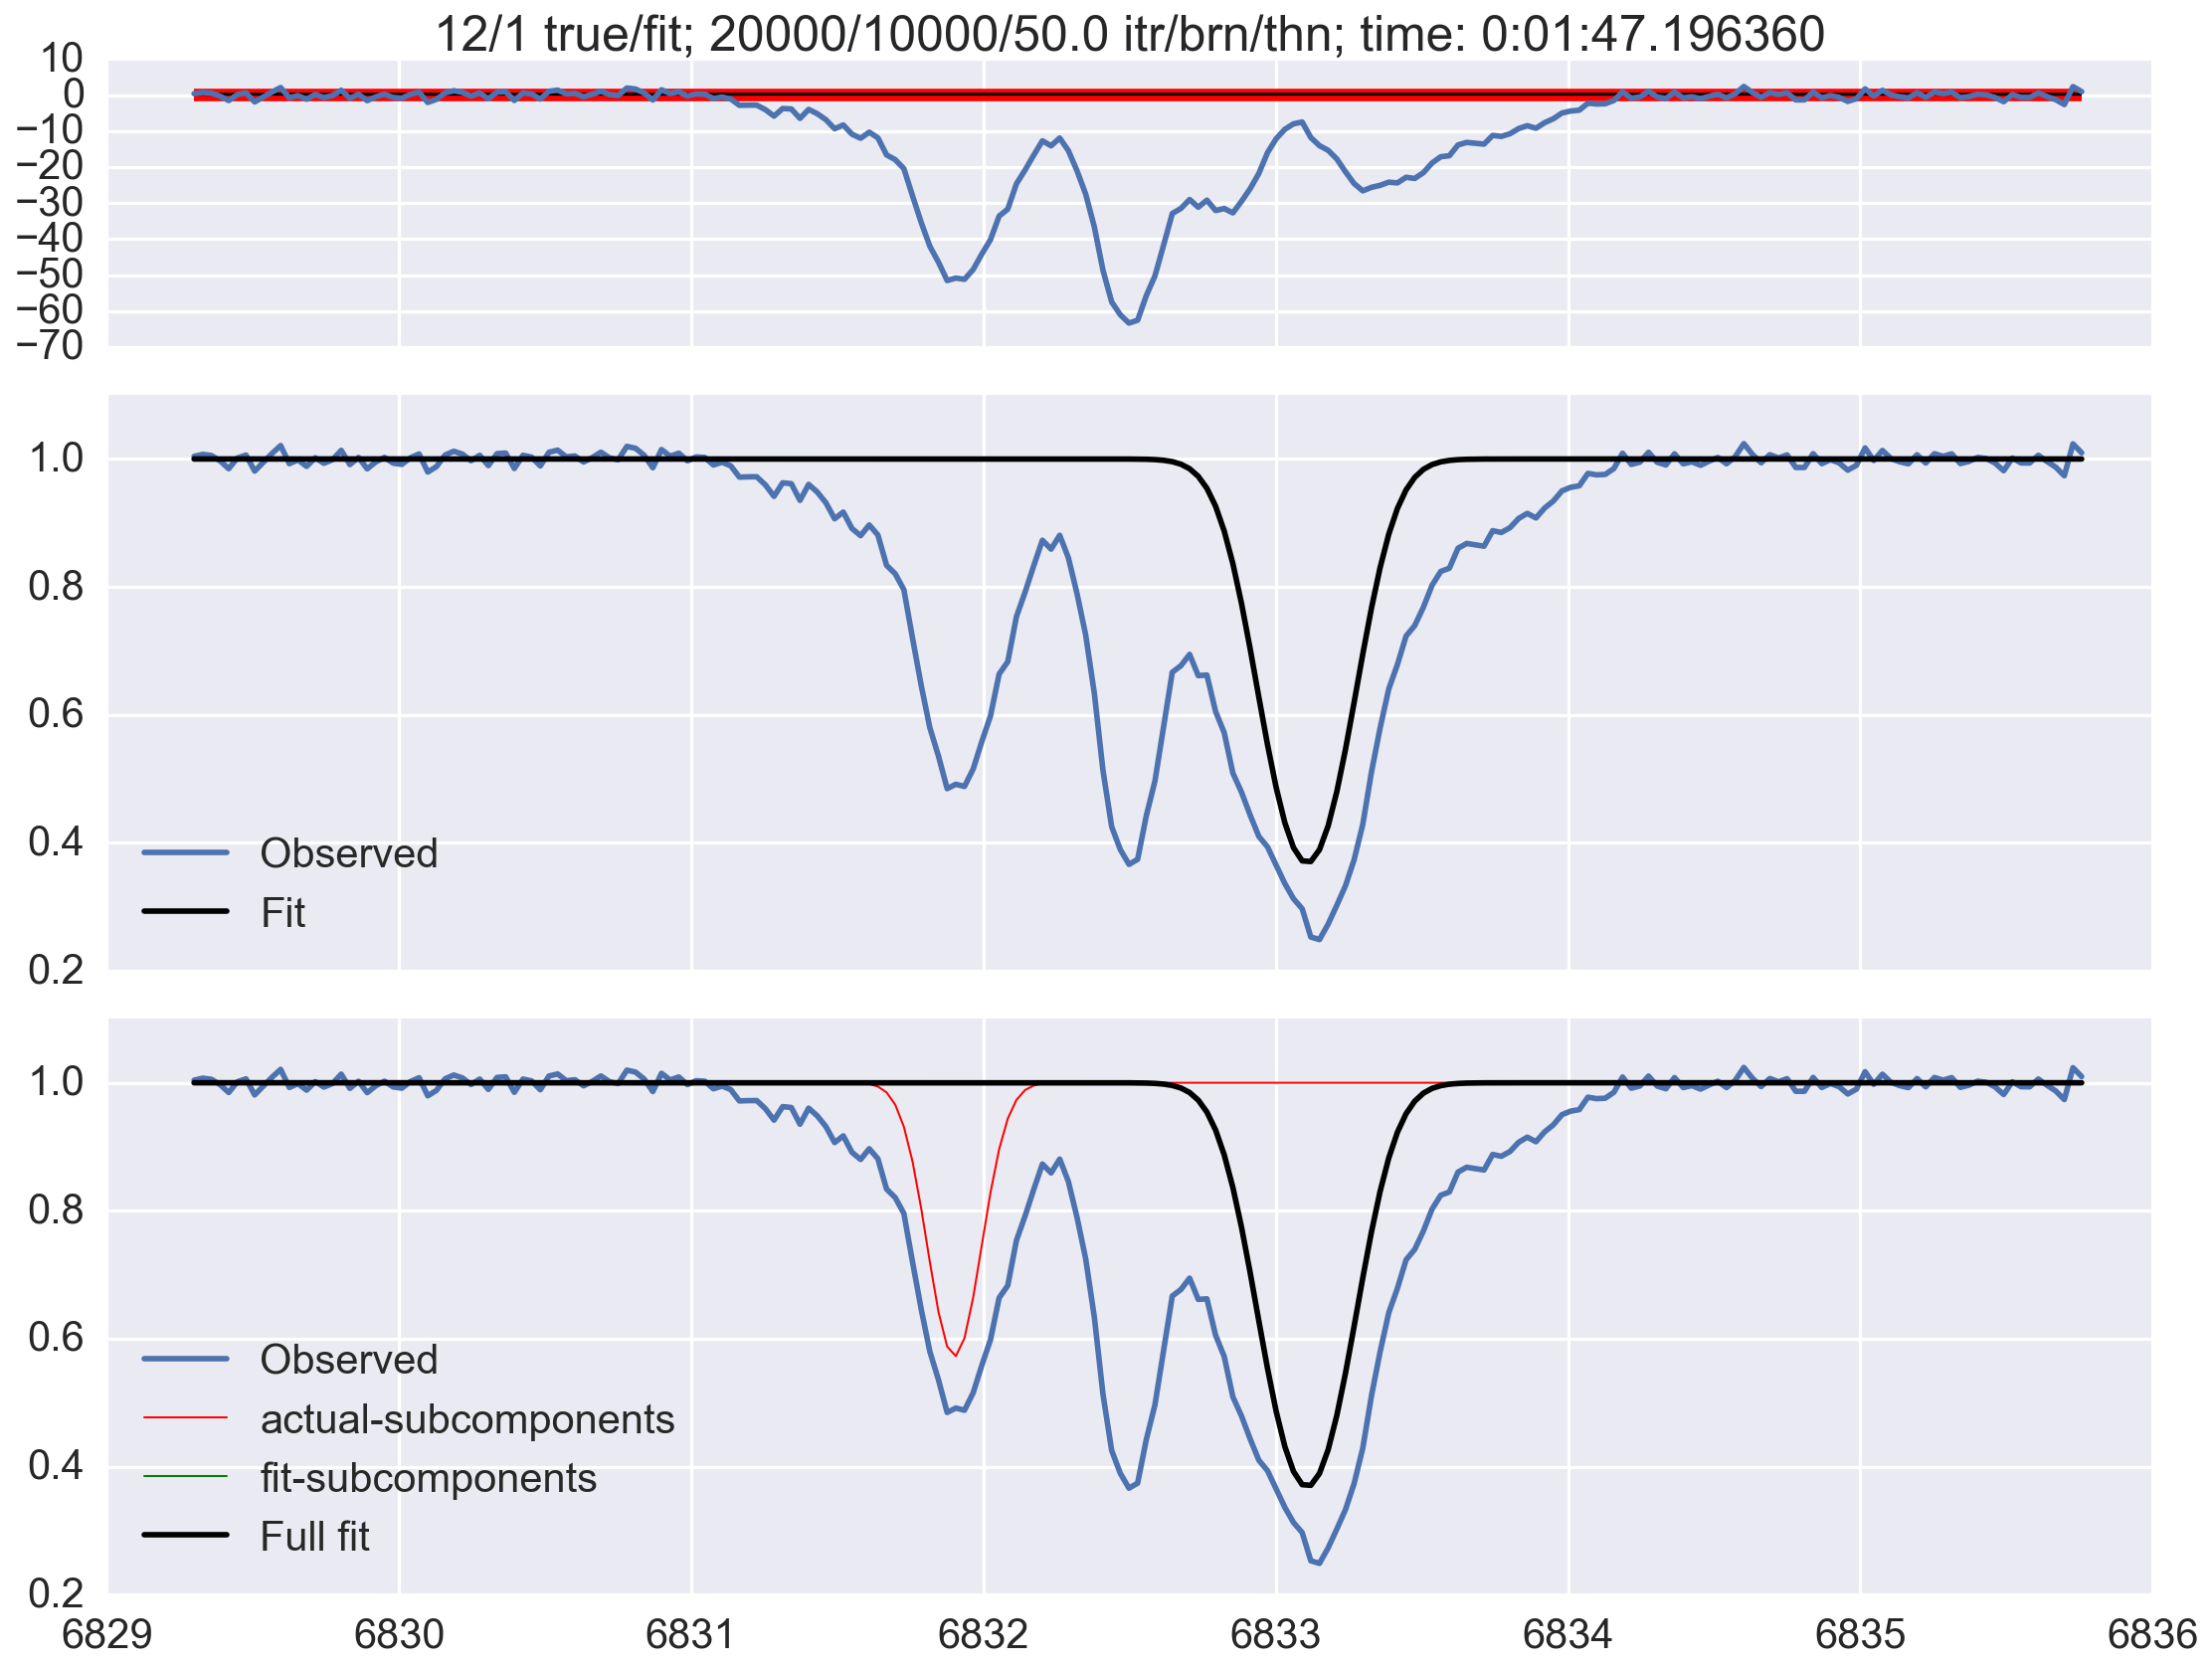

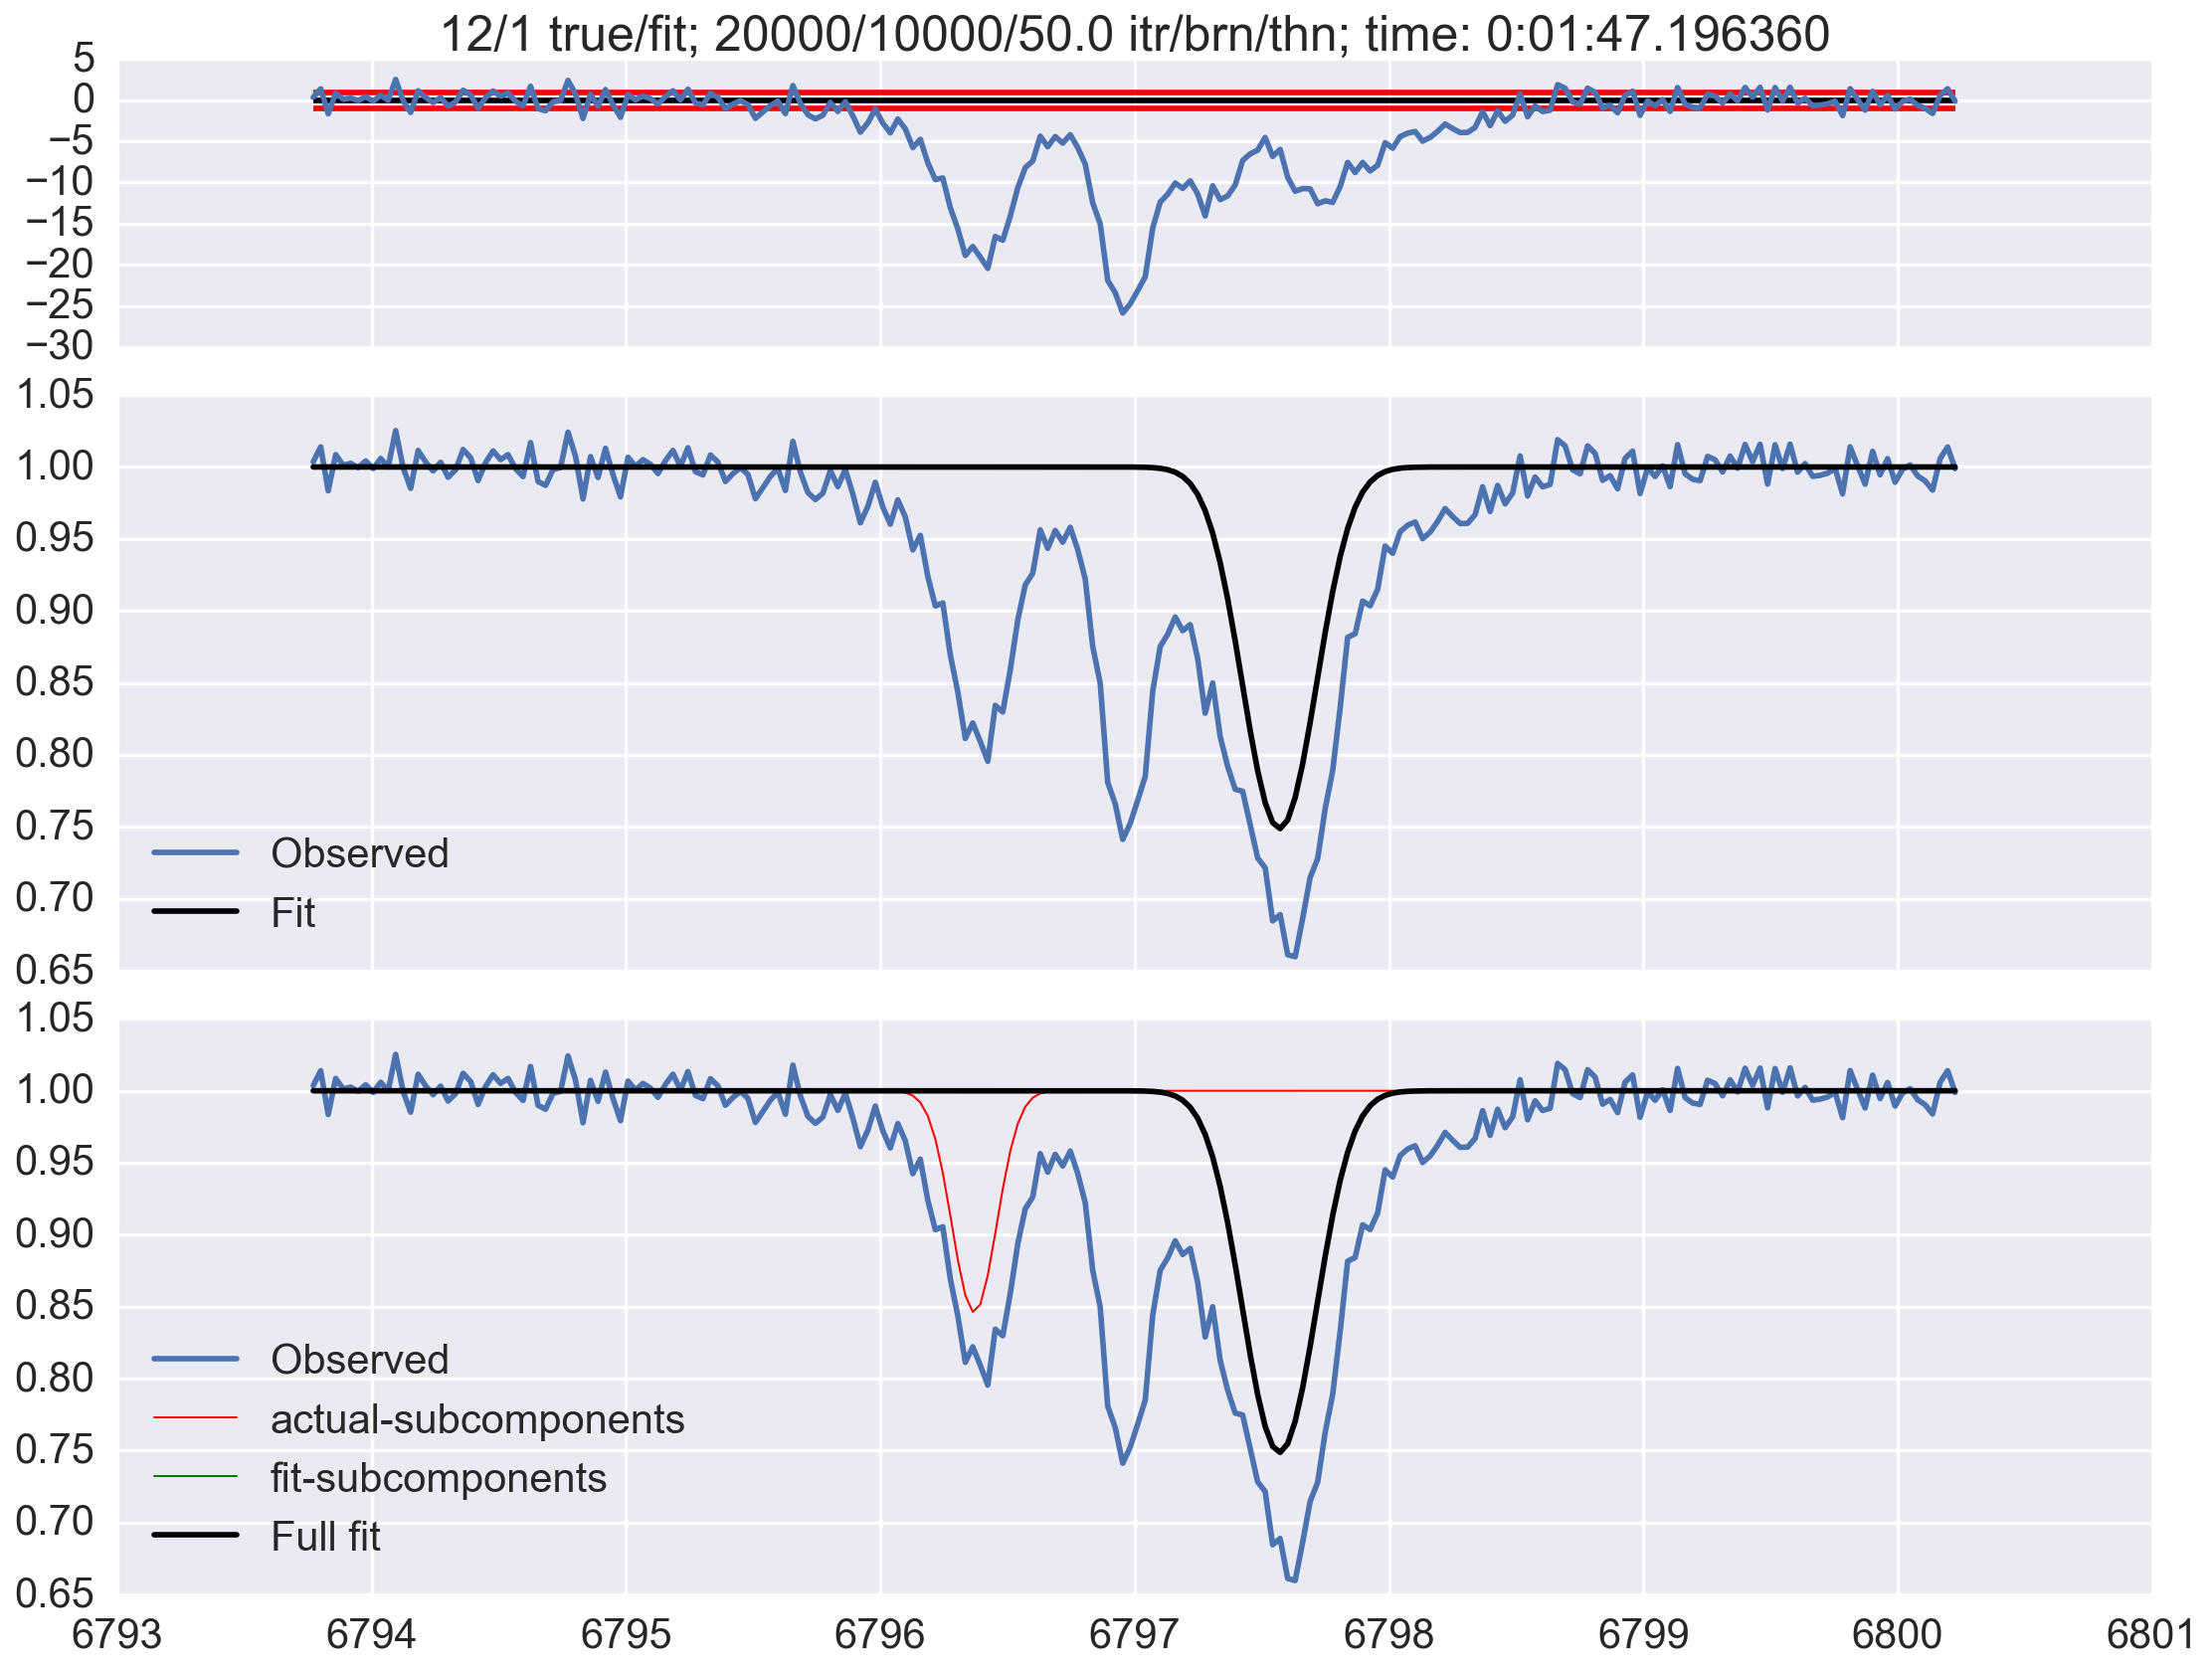

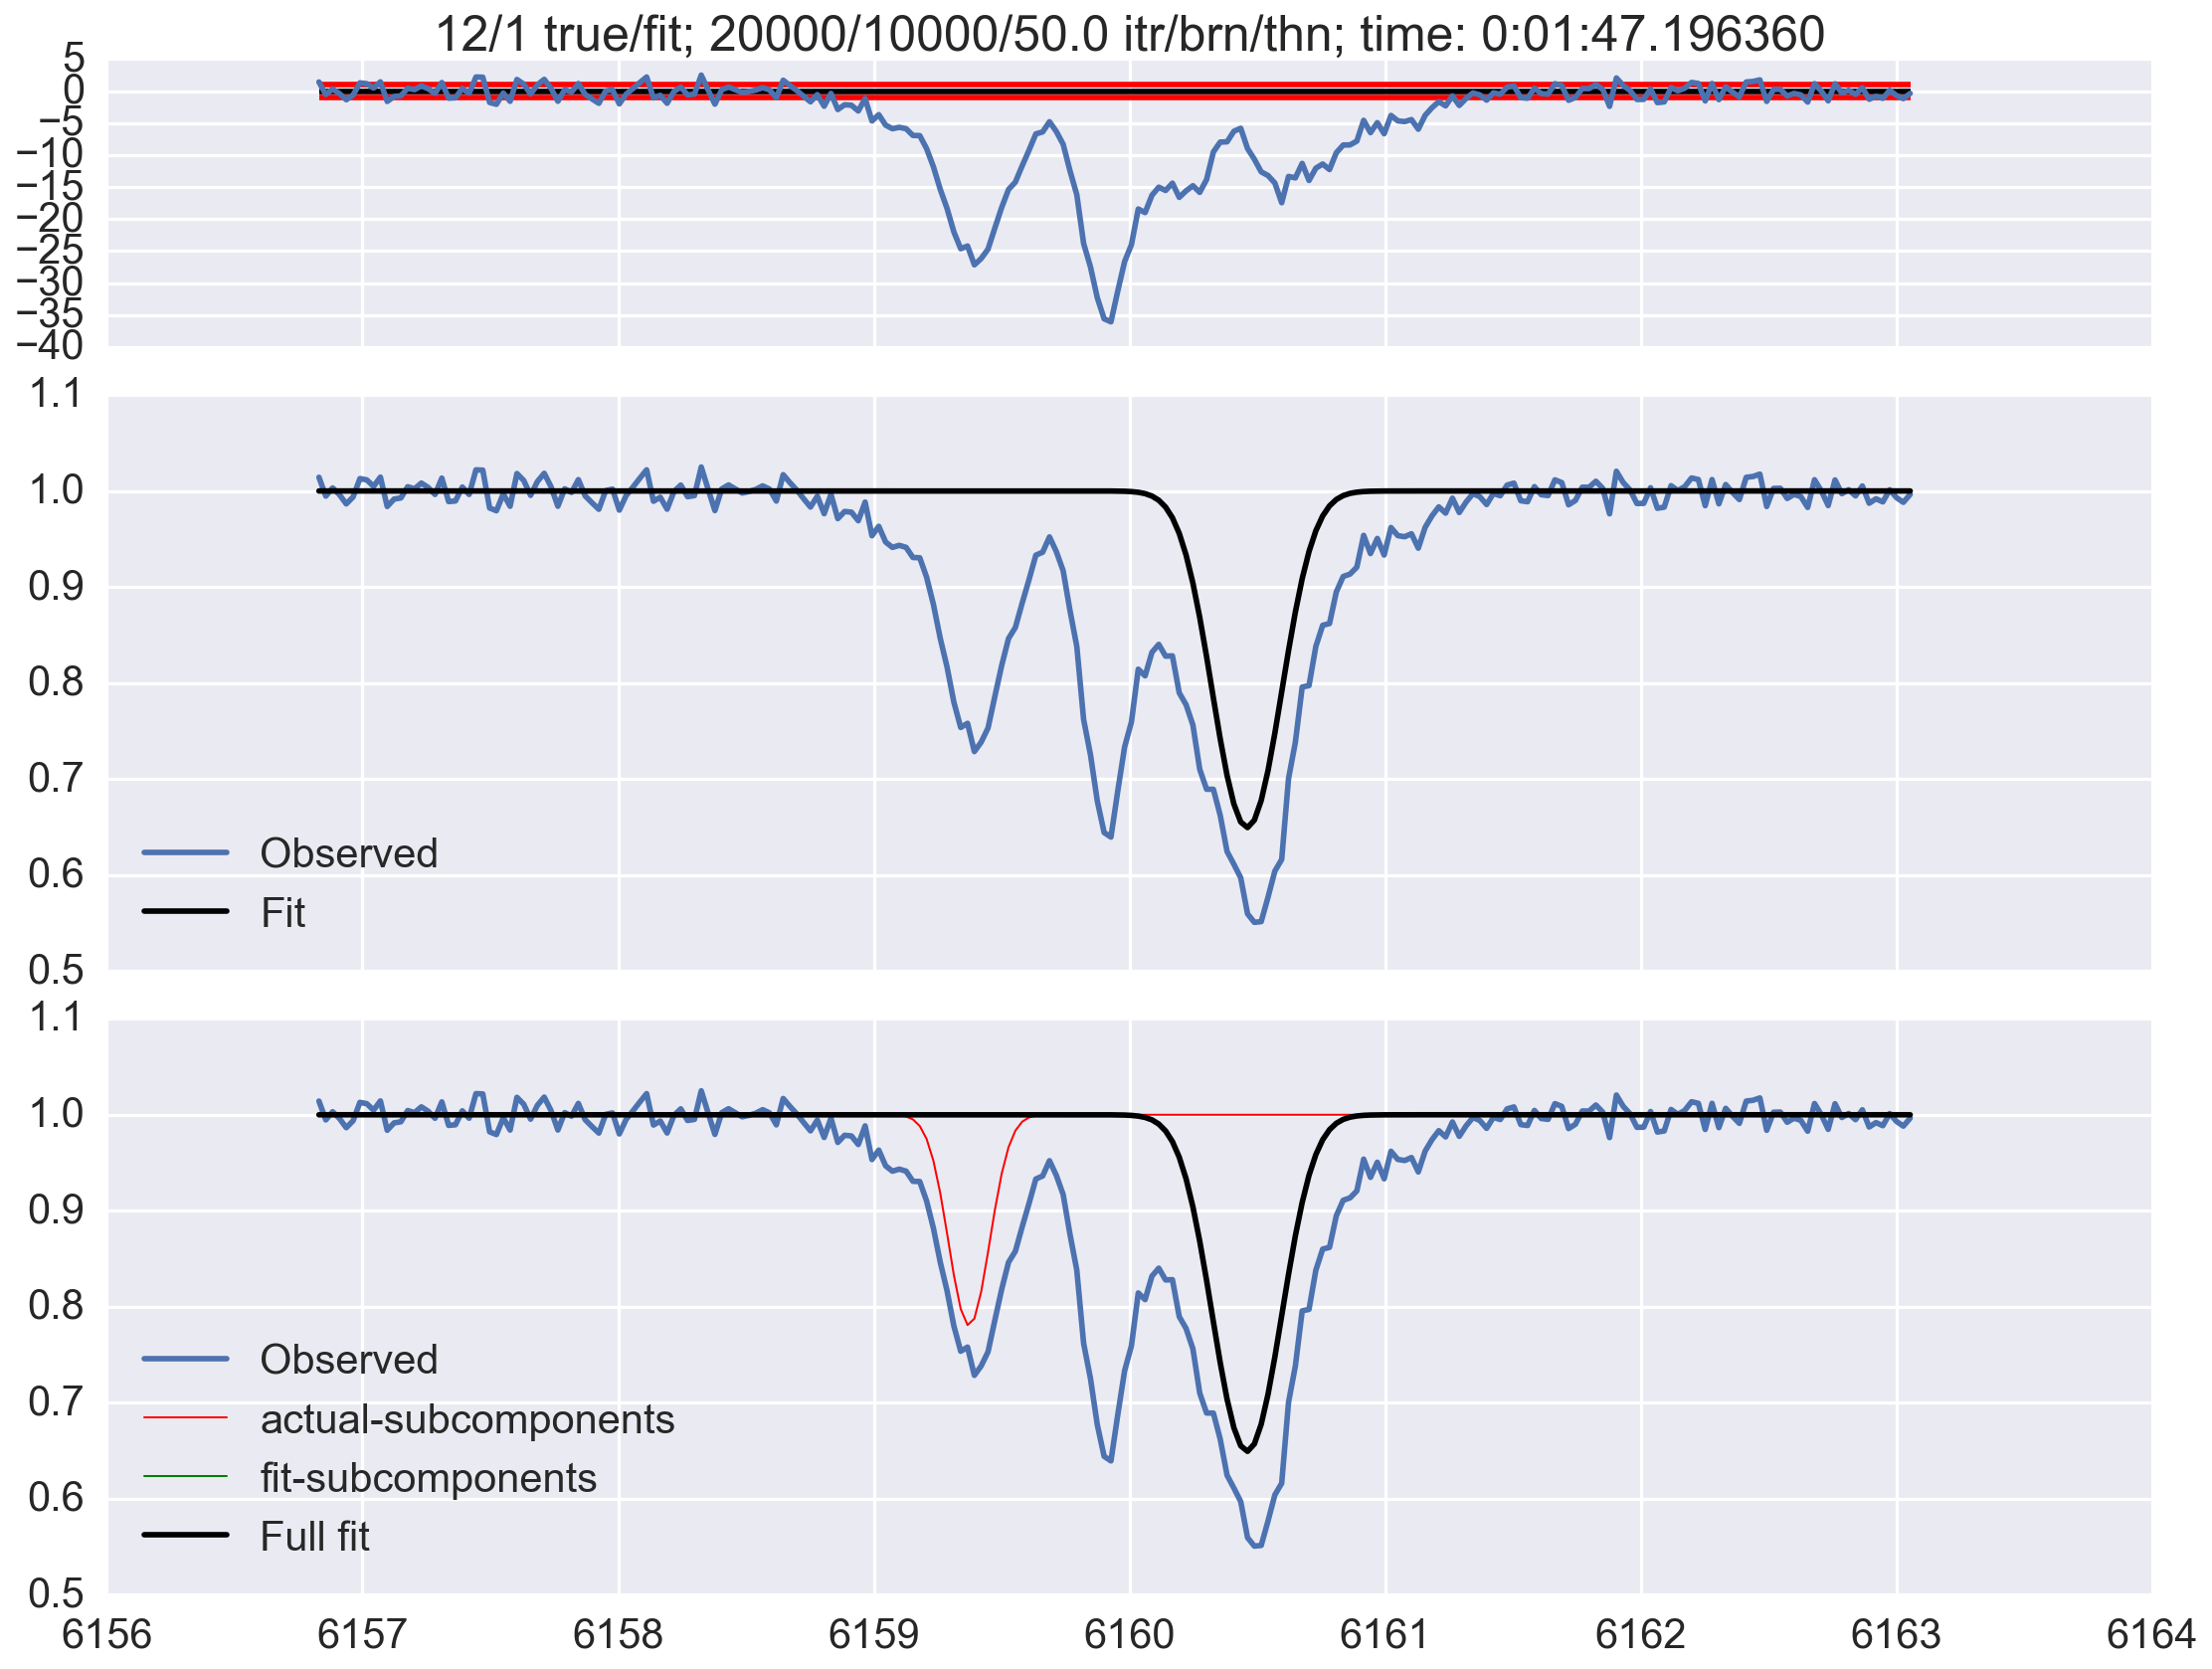

In [85]:
# pdf = PdfPages(datetime.datetime.now().strftime("%Y-%m-%d_%H.%M.%S.flux") + ".pdf")

for region_index, region_wavelength in enumerate(wavelengthList):
    f = plt.figure(figsize=(16, 12))
    gs = GridSpec(3, 1, height_ratios=[1, 2, 2])
    ax3 = plt.subplot(gs[2])
    ax1 = plt.subplot(gs[0], sharex=ax3)
    ax2 = plt.subplot(gs[1], sharex=ax3)
    ax1.plot(wavelengthList[region_index], (observed[region_index] - fit_flux[region_index]['flux']) / onesigmaerror)
    ax1.hlines(1.0, wavelengthList[region_index][0], wavelengthList[region_index][-1], color='red', linestyles='-')
    ax1.hlines(0, wavelengthList[region_index][0], wavelengthList[region_index][-1], color='black')
    ax1.hlines(-1.0, wavelengthList[region_index][0], wavelengthList[region_index][-1], color='red', linestyles='-')
    ax2.plot(wavelengthList[region_index], observed[region_index], label="Observed")
    ax2.plot(wavelengthList[region_index], fit_flux[region_index]['flux'], color='black', label="Fit")
    ax2.legend(loc='best')
    ax3.plot(wavelengthList[region_index], observed[region_index], label="Observed")
    for observed_index, row in enumerate(true_component_parameters):
        flux = absorb.find_tau(subwavelengthList[region_index], [row], atomDict, )[0]
        flux = convolve.convolve_psf(VoigtAbsorption(co_add_from_subsample(flux)), estimated_instrument_profile)
        if observed_index == 0:
            ax3.plot(wavelengthList[region_index], flux, color="red", label="actual-subcomponents", linewidth=1.0)
        else:
            ax3.plot(wavelengthList[region_index], flux, color="red", linewidth=1.0)
    for final_index, row in enumerate(final_fit):
        flux = absorb.find_tau(subwavelengthList[region_index], [row], atomDict, )[0]
        flux = convolve.convolve_psf(VoigtAbsorption(co_add_from_subsample(flux)), estimated_instrument_profile)
        if final_index == 0:
            ax3.plot(wavelengthList[region_index], flux, color="green", label="fit-subcomponents", linewidth=1.0)
        else:
            ax3.plot(wavelengthList[region_index], flux, color="green", linewidth=1.0)
    ax3.plot(wavelengthList[region_index], fit_flux[region_index]['flux'], color='black', label="Full fit")
    ax3.legend(loc='best')
    ax3.xaxis.set_major_formatter(x_formatter)
    xticklabels = ax1.get_xticklabels() + ax2.get_xticklabels()
    plt.setp(xticklabels, visible=False)
    f.tight_layout()
    f.subplots_adjust(hspace=.10)
    ax1.set_title(str(true_components) + "/" 
                  + str(fit_components) 
                  + " true/fit; " + str(iterations)+ "/" 
                  + str(burn) + "/" + str(thin) + " itr/brn/thn; time: " + sampletime)
#     pdf.savefig()
#     plt.close()
# pdf.close()
